In [ ]:
# 📘 FX Reinforcement Learning System（簡易版）
"""
- 作成者：fxinsightslab
- バージョン：v1.0
- 公開日：2025年4月xx日
- ライセンス：個人利用限定（再配布・商用利用・改変配布禁止）

---

## 📄 利用に関する注意事項

- このノートブックは学習・研究・検証目的で提供されています。
- 実際の売買判断やトレード運用は自己責任の下で行ってください。
- 本テンプレートを改変しての再配布、または第三者への提供・販売は禁止です。

> 💬 ご質問や不具合の報告は、X（旧Twitter）[@fxinsightslab](https://x.com/fxinsightslab) までお気軽にどうぞ！

---

✅ 以下のセルから順次実行すると最後の評価まで行えるようになっています。
"""

In [39]:
# データ準備
################################################################
# 指定されたプロジェクトルートからノートブックを実行し、
# MT5からGOLDのM5データを取得・前処理して表示する
################################################################
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import talib
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from sklearn.preprocessing import StandardScaler
import os


# --- プロジェクトルートを自動検出する関数 ---
def find_project_root(target_folder_name="FX Reinforcement Learning System（簡易版）"):
    current_path = os.getcwd() # 現在の作業ディレクトリを取得
    while True:
        # 現在のフォルダ名がターゲット名と一致するか確認
        if os.path.basename(current_path) == target_folder_name:
            return current_path # 一致すればそのパスを返す
        parent = os.path.dirname(current_path)# 一つ上の階層へ移動
        if parent == current_path:
            # ルートまで探索しても見つからなければエラーを投げる
            raise FileNotFoundError(f"{target_folder_name} フォルダが上位ディレクトリに見つかりませんでした。")
        current_path = parent# 次のループでは上位フォルダを探索

try:# プロジェクトルートのパスを取得し、指定ノートブックを実行
    base_path = find_project_root()  
    target_path = os.path.join(base_path, "src/utils/data_preparation.ipynb").replace("\\", "/")
    %run "$target_path"# ノートブックを実行して関数などを読み込み
except FileNotFoundError as e:
    print(e)# 見つからなければエラーメッセージを表示


# --- MT5からデータ取得 ---
mt5.initialize()  # MT5との接続を初期化
symbol = "GOLD"  # 取得する銘柄を指定
# GOLDの5分足データを「現在の最新の足」から遡って1000本取得
rates = mt5.copy_rates_from_pos(symbol, mt5.TIMEFRAME_M5, 0, 10000)  # 0 は「現在時刻に最も近いバー（=最新バー）を起点」という意味
mt5.shutdown()  # MT5との接続を終了

# --- データフレームに変換・整形 ---
df = pd.DataFrame(rates)  # MT5データをDataFrame形式に変換
df["time"] = pd.to_datetime(df["time"], unit="s")  # UNIX時間を日時形式に変換

# --- 前処理実行（data_preparation.ipynbで定義された関数） ---
df = prepare_data(df)  # 指定関数でテクニカル指標などを追加・整形

# --- 結果表示（先頭5行） ---
print(df.head())  # データの先頭を表示して確認

                  time      open      high       low     close  tick_volume  \
49 2025-03-06 11:00:00 -1.356495 -1.361035 -1.384689 -1.384640         1161   
50 2025-03-06 11:05:00 -1.384241 -1.371429 -1.377494 -1.367518          855   
51 2025-03-06 11:10:00 -1.367187 -1.359483 -1.362494 -1.358246          785   
52 2025-03-06 11:15:00 -1.358119 -1.362925 -1.369417 -1.376316          715   
53 2025-03-06 11:20:00 -1.375849 -1.378179 -1.376408 -1.379429          960   

    spread  real_volume    volume  raw_close    SMA_20    EMA_50    RSI_14  \
49      27            0  0.912459    2900.49 -1.327968 -1.282551 -2.110838   
50      27            0  0.217920    2903.02 -1.332375 -1.285730 -1.421130   
51      27            0  0.059039    2904.39 -1.335899 -1.288420 -1.086519   
52      27            0 -0.099843    2901.72 -1.340221 -1.291715 -1.461098   
53      27            0  0.456242    2901.26 -1.344906 -1.295002 -1.521320   

        MACD    ATR_14  BB_upper  BB_lower       OBV  zi

In [31]:
import numpy as np
from stable_baselines3 import PPO
import torch
import torch.nn.functional as F

# ========== サブAI（トレンドAI・ボラティリティAI）をラップするユーティリティクラス ==========
################################################################
# obs 受け取り	強化学習環境からの状態を受け取る
# .predict()	PPOモデルでアクションを推論
# softmax(logits)	推論アクションの信頼度スコアを取得
# 出力形式	AIタイプに応じてラベル付きの辞書で返す（trend_ or volatility_）
################################################################
class SubAIWrapper:
    def __init__(self, model, ai_type="trend"):
        self.model = model  # 強化学習モデル（PPO）
        self.ai_type = ai_type  # AIの種類を指定（"trend" または "volatility"）

    def predict(self, obs):
        # --- 入力観測ベクトルを reshape（バッチ形式）---
        obs_reshaped = obs.reshape(1, -1)

        # 🔮 モデルからアクションを決定（deterministic=True → 確定的な予測）
        action, _ = self.model.predict(obs_reshaped, deterministic=True)

        # 🔍 信頼度スコア（Softmaxからアクション確率）を計算 ---
        with torch.no_grad():  # 勾配計算オフ
            obs_tensor = torch.tensor(obs_reshaped, dtype=torch.float32)  # Tensorに変換
            logits = self.model.policy.mlp_extractor.forward_actor(obs_tensor)  # ロジットを取得
            probs = F.softmax(logits, dim=1).cpu().numpy()[0]  # Softmaxで確率に変換
            confidence_or_score = float(probs[action])  # 選択したアクションの確率を抽出

        # --- 結果を種類ごとに出力フォーマット変換 ---
        if self.ai_type == "trend":
            action_label = ["Hold", "Buy", "Sell"][action]
            return {
                "trend_action": action_label,
                "trend_confidence": confidence_or_score
            }

        elif self.ai_type == "volatility":
            action_label = ["Hold", "Avoid", "Entry"][action]
            return {
                "volatility_action": action_label,
                "volatility_score": confidence_or_score
            }


In [32]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import torch
import torch.nn.functional as F

# ========== マネージャーAI用の統合環境 ==========
##################################################
# 状態空間（21次元）	トレンドAI＋ボラティリティAI の出力 + 信頼度 + テクニカル指標
# 行動空間（4種類）	0=保留、1=買い、2=売り、3=決済（exit）
# 報酬関数	価格差＋含み益＋コスト＋不正行動ペナルティ
# run_backtest()	シグナル記録機能付きの簡易シミュレーション
##################################################
class RealDataManagerEnv(gym.Env):
    def __init__(self, df, trend_model, vol_model):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.trend_model = trend_model  # SubAIWrapper(trend_model)
        self.vol_model = vol_model      # SubAIWrapper(vol_model)
        self.current_step = 0
        self.max_steps = len(df) - 1

        # 状態空間（21次元）：trend(3) + vol(3) + confidence(2) + 技術指標(13)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(21,), dtype=np.float32)

        # 行動空間：0=Hold, 1=Long, 2=Short, 3=Close
        self.action_space = spaces.Discrete(4)

        self.position = None          # 現在のポジション状態（"long", "short", None）
        self.entry_price = None       # エントリー価格

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.position = None
        self.entry_price = None
        return self._get_obs(), {}

    # --- 状態ベクトルの構築（SubAI + テクニカル指標）---
    def _get_obs(self):
        row = self.df.iloc[self.current_step]
        obs_vector = np.array([
            row["close"], row["SMA_20"], row["RSI_14"], row["MACD"], row["ATR_14"],
            row["BB_upper"], row["BB_lower"], row.get("volume", 0.0),
            row["open"], row["high"], row["low"], row["EMA_50"],
            row["OBV"]
        ], dtype=np.float32)

        # SubAIのアクション＆信頼度を取得（ワンホット + 信頼度スコア）
        trend_action, _ = self.trend_model.model.predict(obs_vector.reshape(1, -1), deterministic=True)
        vol_action, _ = self.vol_model.model.predict(obs_vector.reshape(1, -1), deterministic=True)

        trend_confidence = [self._get_confidence(self.trend_model, obs_vector)]
        vol_score = [self._get_confidence(self.vol_model, obs_vector)]

        trend_onehot = np.eye(3)[int(trend_action)]
        vol_onehot = np.eye(3)[int(vol_action)]

        # 統合された状態ベクトルを返す
        return np.concatenate([trend_onehot, vol_onehot, trend_confidence, vol_score, obs_vector], dtype=np.float32)

    # --- 環境1ステップの処理 ---
    def step(self, action):
        reward = self._calc_reward(action)
        self.current_step += 1
        terminated = self.current_step >= self.max_steps
        truncated = False
        return self._get_obs(), reward, terminated, truncated, {"position": self.position}

    # --- 報酬関数（価格差とポジション状況に基づく）---
    def _calc_reward(self, action):
        price_now = self.df["close"].iloc[self.current_step]
        TRADING_COST = 0.05
        reward = 0.0

        # 保留中：保有ポジションの含み益/損を反映
        if action == 0:  # Hold
            if self.position is not None and self.entry_price is not None:
                unrealized = price_now - self.entry_price if self.position == "long" else self.entry_price - price_now
                reward += unrealized * 0.1  # 含み益評価
            else:
                reward = -0.001  # 何もしないペナルティ

        elif action == 1:  # Long
            reward -= TRADING_COST
            if self.position is None:
                self.position = "long"
                self.entry_price = price_now
            elif self.position == "short":
                pnl = self.entry_price - price_now
                reward += pnl
                self.position = "long"
                self.entry_price = price_now

        elif action == 2:  # Short
            reward -= TRADING_COST
            if self.position is None:
                self.position = "short"
                self.entry_price = price_now
            elif self.position == "long":
                pnl = price_now - self.entry_price
                reward += pnl
                self.position = "short"
                self.entry_price = price_now

        elif action == 3:  # Close
            if self.position is not None:
                if self.position == "long":
                    reward += price_now - self.entry_price
                elif self.position == "short":
                    reward += self.entry_price - price_now
                self.position = None
                self.entry_price = None
            else:
                reward = -1  # ポジションがないのにClose → ペナルティ

        return reward

    # --- SubAIのSoftmax信頼度を計算 ---
    def _get_confidence(self, model, obs_vector):
        obs_tensor = torch.tensor(obs_vector, dtype=torch.float32).unsqueeze(0)
        logits = model.model.policy.mlp_extractor.forward_actor(obs_tensor)
        probs = F.softmax(logits, dim=1).detach().numpy()[0]
        return float(np.max(probs))  # 最も強く選ばれたアクションの確率

    # --- バックテストモード：AIの行動ログを記録 ---
    def run_backtest(self, model, max_steps=1000):
        obs, _ = self.reset()
        self.signals = []

        for _ in range(max_steps):
            action, _ = model.predict(obs, deterministic=True)
            action = int(action)

            if action in [1, 2]:  # ロング or ショート
                pos_type = "long" if action == 1 else "short"

                if self.position is None:
                    self.signals.append((self.current_step, "entry", pos_type))

                elif self.position != pos_type:
                    self.signals.append((self.current_step, "exit", self.position))
                    self.signals.append((self.current_step, "entry", pos_type))

            elif action == 3 and self.position is not None:
                self.signals.append((self.current_step, "exit", self.position))

            obs, reward, terminated, truncated, _ = self.step(action)

            if terminated or truncated:
                break

        # 最後にポジションが残っていた場合、明示的に終了処理
        if self.position is not None:
            self.signals.append((self.current_step, "exit", self.position))

        return self.signals


In [50]:
import os
from stable_baselines3 import PPO
import zipfile
# --- モデルの読み込み処理 ---
try:
    base_path = find_project_root()
    model_path = os.path.join(base_path, "src/agents/models/trend_ai_ppo.zip")

    if os.path.exists(model_path):
        print("✅ モデルファイルが見つかりました:", model_path)

        try:
            model = PPO.load(model_path)
            print("✅ モデルの読み込みに成功しました！")

            with zipfile.ZipFile(model_path, 'r') as zip_ref:
                print("📦 含まれるファイル一覧:")
                for name in zip_ref.namelist():
                    print("  -", name)

        except Exception as e:
            print("❌ モデルの読み込みに失敗しました:", e)
    else:
        print("❌ モデルファイルが存在しません:", model_path)

except FileNotFoundError as e:
    print("❌ エラー:", e)
# モデル読み込み
trend_model = model

# --- モデルの読み込み処理 ---
try:
    base_path = find_project_root()
    model_path = os.path.join(base_path, "src/agents/models/volatility_ai_ppo.zip")

    if os.path.exists(model_path):
        print("✅ モデルファイルが見つかりました:", model_path)

        try:
            model = PPO.load(model_path)
            print("✅ モデルの読み込みに成功しました！")

            with zipfile.ZipFile(model_path, 'r') as zip_ref:
                print("📦 含まれるファイル一覧:")
                for name in zip_ref.namelist():
                    print("  -", name)

        except Exception as e:
            print("❌ モデルの読み込みに失敗しました:", e)
    else:
        print("❌ モデルファイルが存在しません:", model_path)

except FileNotFoundError as e:
    print("❌ エラー:", e)
    
# モデル読み込み
vol_model = model

# --- モデルの読み込み処理 ---
try:
    base_path = find_project_root()
    model_path = os.path.join(base_path, "src/manager/models/manager_ai_ppo.zip")

    if os.path.exists(model_path):
        print("✅ モデルファイルが見つかりました:", model_path)

        try:
            model = PPO.load(model_path)
            print("✅ モデルの読み込みに成功しました！")

            with zipfile.ZipFile(model_path, 'r') as zip_ref:
                print("📦 含まれるファイル一覧:")
                for name in zip_ref.namelist():
                    print("  -", name)

        except Exception as e:
            print("❌ モデルの読み込みに失敗しました:", e)
    else:
        print("❌ モデルファイルが存在しません:", model_path)

except FileNotFoundError as e:
    print("❌ エラー:", e)

# モデル読み込み
manager_model = model

✅ モデルファイルが見つかりました: C:\Users\kotak\FX Reinforcement Learning System（簡易版）\src/agents/models/trend_ai_ppo.zip
✅ モデルの読み込みに成功しました！
📦 含まれるファイル一覧:
  - data
  - pytorch_variables.pth
  - policy.pth
  - policy.optimizer.pth
  - _stable_baselines3_version
  - system_info.txt
✅ モデルファイルが見つかりました: C:\Users\kotak\FX Reinforcement Learning System（簡易版）\src/agents/models/volatility_ai_ppo.zip
✅ モデルの読み込みに成功しました！
📦 含まれるファイル一覧:
  - data
  - pytorch_variables.pth
  - policy.pth
  - policy.optimizer.pth
  - _stable_baselines3_version
  - system_info.txt
✅ モデルファイルが見つかりました: C:\Users\kotak\FX Reinforcement Learning System（簡易版）\src/manager/models/manager_ai_ppo.zip
✅ モデルの読み込みに成功しました！
📦 含まれるファイル一覧:
  - data
  - pytorch_variables.pth
  - policy.pth
  - policy.optimizer.pth
  - _stable_baselines3_version
  - system_info.txt


In [48]:
from stable_baselines3 import PPO

# --- モデルの読み込み（必要に応じてコメントアウト解除）---
# trend_model = PPO.load("trend_ai_ppo")  # 学習済みトレンドAIモデル
# vol_model   = PPO.load("volatility_ai_ppo")  # 学習済みボラティリティAIモデル

# --- モデルの読み込み or 新規作成を行う関数 ---
def load_or_create_model(env, model_name="manager_ai_ppo", force_new=False, verbose=1):
    """
    モデルの読み込み or 新規作成

    Parameters:
        env: 強化学習環境（Monitor付き）
        model_name: モデルの保存ファイル名（拡張子なし）
        force_new: Trueなら既存モデルを無視して新規作成
        verbose: PPOの出力詳細レベル

    Returns:
        PPOモデルインスタンス
    """
    base_path = find_project_root()  # プロジェクトルートパスを取得
    model_path = os.path.join(base_path, f"src/manager/models/{model_name}.zip")  # モデルファイルパスを生成

    # 既存モデルがあり、再学習指示でなければロード
    if os.path.exists(model_path) and not force_new:
        print(f"✅ 既存モデル '{model_name}' を読み込みます。")
        model = PPO.load(model_path)
        model.set_env(env)  # 環境を再設定（再学習時に必要）
    else:
        # 既存ファイルがあっても force_new = True の場合は上書き
        if os.path.exists(model_path):
            print(f"🆕 モデル '{model_name}' を上書きして新規学習します。")
        else:
            print(f"🆕 モデル '{model_name}' が存在しないため、新規に作成します。")
        model = PPO("MlpPolicy", env, verbose=verbose)  # 新規モデル作成

    return model

# --- 必要な補助ツールのインポート ---
from stable_baselines3.common.monitor import Monitor  # ログ記録用ラッパー
from stable_baselines3.common.env_checker import check_env  # 環境構成の妥当性チェック

# --- SubAIWrapper を使用してソフトマックス信頼度を取得できる形式に変換 ---
trend_wrapper = SubAIWrapper(trend_model, ai_type="trend")
vol_wrapper   = SubAIWrapper(vol_model, ai_type="volatility")

# --- 統合環境の選択（実データ or テスト用）---
env = RealDataManagerEnv(df, trend_wrapper, vol_wrapper)  # ✅ 実データを用いた学習環境
# env = ManagerEnv(trend_wrapper, vol_wrapper)            # （テスト用）ダミー環境があれば切替

# --- 学習設定（force_train=Trueで新規学習を強制）---
force_train = False  # ← Trueなら新規に学習を始める、Falseなら保存済みモデルを再利用

# --- モデル取得（ロード or 新規作成）---
model = load_or_create_model(env, model_name="manager_ai_ppo", force_new=force_train)

# --- PPOモデルの学習 ---
model.learn(total_timesteps=5000000)  # 学習ステップ数は調整可能

# --- モデルの保存（自動で .zip 拡張子が付加される）---
model.save("models/manager_ai_ppo")
print("✅ Manager AI PPO 学習完了！")


✅ 既存モデル 'manager_ai_ppo' を読み込みます。
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 385  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 263         |
|    iterations           | 2           |
|    time_elapsed         | 15          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017892778 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.534      |
|    explained_variance   | -0.171      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.151       |
|    n_updates            | 11280       |
|    policy_gradient_loss | -0.0161     |
|    va

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -94.3       |
| time/                   |             |
|    fps                  | 197         |
|    iterations           | 12          |
|    time_elapsed         | 124         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.013766975 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.533      |
|    explained_variance   | 0.786       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0115      |
|    n_updates            | 11380       |
|    policy_gradient_loss | -0.0117     |
|    value_loss           | 0.0495      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 9.95e+03      |
|    ep_rew_mean          | -79.3         |
| time/                   |               |
|    fps                  | 195           |
|    iterations           | 22            |
|    time_elapsed         | 230           |
|    total_timesteps      | 45056         |
| train/                  |               |
|    approx_kl            | 0.00071555306 |
|    clip_fraction        | 0.00542       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0594       |
|    explained_variance   | 0.673         |
|    learning_rate        | 0.0003        |
|    loss                 | 0.00959       |
|    n_updates            | 11480         |
|    policy_gradient_loss | -0.00173      |
|    value_loss           | 0.0141        |
-------------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -70.1       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 32          |
|    time_elapsed         | 340         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.005429729 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.126      |
|    explained_variance   | 0.466       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00325    |
|    n_updates            | 11580       |
|    policy_gradient_loss | -0.00396    |
|    value_loss           | 0.0096      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -64.7        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 42           |
|    time_elapsed         | 449          |
|    total_timesteps      | 86016        |
| train/                  |              |
|    approx_kl            | 0.0015656757 |
|    clip_fraction        | 0.0167       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0701      |
|    explained_variance   | 0.235        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00158      |
|    n_updates            | 11680        |
|    policy_gradient_loss | -0.00498     |
|    value_loss           | 0.00544      |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -56.7       |
| time/                   |             |
|    fps                  | 189         |
|    iterations           | 52          |
|    time_elapsed         | 560         |
|    total_timesteps      | 106496      |
| train/                  |             |
|    approx_kl            | 0.002240615 |
|    clip_fraction        | 0.0163      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0628     |
|    explained_variance   | 0.329       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00451    |
|    n_updates            | 11780       |
|    policy_gradient_loss | -0.0061     |
|    value_loss           | 0.00802     |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -53.6        |
| time/                   |              |
|    fps                  | 189          |
|    iterations           | 62           |
|    time_elapsed         | 668          |
|    total_timesteps      | 126976       |
| train/                  |              |
|    approx_kl            | 0.0023627826 |
|    clip_fraction        | 0.0212       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0755      |
|    explained_variance   | 0.83         |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00763     |
|    n_updates            | 11880        |
|    policy_gradient_loss | -0.00513     |
|    value_loss           | 0.00868      |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -49.8       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 72          |
|    time_elapsed         | 765         |
|    total_timesteps      | 147456      |
| train/                  |             |
|    approx_kl            | 0.005129416 |
|    clip_fraction        | 0.0419      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.189      |
|    explained_variance   | 0.705       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00512     |
|    n_updates            | 11980       |
|    policy_gradient_loss | -0.0104     |
|    value_loss           | 0.0382      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95e+03   |
|    ep_rew_mean          | -46.6      |
| time/                   |            |
|    fps                  | 192        |
|    iterations           | 82         |
|    time_elapsed         | 874        |
|    total_timesteps      | 167936     |
| train/                  |            |
|    approx_kl            | 0.00604037 |
|    clip_fraction        | 0.0564     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.214     |
|    explained_variance   | 0.858      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.00654    |
|    n_updates            | 12080      |
|    policy_gradient_loss | -0.0101    |
|    value_loss           | 0.0402     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -44.9        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 92           |
|    time_elapsed         | 985          |
|    total_timesteps      | 188416       |
| train/                  |              |
|    approx_kl            | 0.0051500257 |
|    clip_fraction        | 0.0322       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.134       |
|    explained_variance   | 0.69         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0206       |
|    n_updates            | 12180        |
|    policy_gradient_loss | -0.00721     |
|    value_loss           | 0.0643       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -50.7       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 102         |
|    time_elapsed         | 1091        |
|    total_timesteps      | 208896      |
| train/                  |             |
|    approx_kl            | 0.011095161 |
|    clip_fraction        | 0.0454      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.194      |
|    explained_variance   | -0.992      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00102     |
|    n_updates            | 12280       |
|    policy_gradient_loss | -0.0114     |
|    value_loss           | 0.0368      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -61.3       |
| time/                   |             |
|    fps                  | 190         |
|    iterations           | 112         |
|    time_elapsed         | 1204        |
|    total_timesteps      | 229376      |
| train/                  |             |
|    approx_kl            | 0.010776874 |
|    clip_fraction        | 0.0781      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.295      |
|    explained_variance   | 0.839       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00774     |
|    n_updates            | 12380       |
|    policy_gradient_loss | -0.0101     |
|    value_loss           | 0.0158      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -60.3       |
| time/                   |             |
|    fps                  | 189         |
|    iterations           | 122         |
|    time_elapsed         | 1318        |
|    total_timesteps      | 249856      |
| train/                  |             |
|    approx_kl            | 0.007508541 |
|    clip_fraction        | 0.0608      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.353      |
|    explained_variance   | 0.97        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.000559    |
|    n_updates            | 12480       |
|    policy_gradient_loss | -0.0107     |
|    value_loss           | 0.014       |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -57.4       |
| time/                   |             |
|    fps                  | 188         |
|    iterations           | 132         |
|    time_elapsed         | 1435        |
|    total_timesteps      | 270336      |
| train/                  |             |
|    approx_kl            | 0.013443019 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.47       |
|    explained_variance   | 0.859       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.02       |
|    n_updates            | 12580       |
|    policy_gradient_loss | -0.00949    |
|    value_loss           | 0.024       |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -57.5       |
| time/                   |             |
|    fps                  | 187         |
|    iterations           | 142         |
|    time_elapsed         | 1549        |
|    total_timesteps      | 290816      |
| train/                  |             |
|    approx_kl            | 0.008610062 |
|    clip_fraction        | 0.0885      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.447      |
|    explained_variance   | 0.912       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0098      |
|    n_updates            | 12680       |
|    policy_gradient_loss | -0.0107     |
|    value_loss           | 0.0412      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -55.3       |
| time/                   |             |
|    fps                  | 188         |
|    iterations           | 152         |
|    time_elapsed         | 1654        |
|    total_timesteps      | 311296      |
| train/                  |             |
|    approx_kl            | 0.009637445 |
|    clip_fraction        | 0.0653      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.3        |
|    explained_variance   | 0.912       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00862     |
|    n_updates            | 12780       |
|    policy_gradient_loss | -0.00882    |
|    value_loss           | 0.0266      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -53.9       |
| time/                   |             |
|    fps                  | 188         |
|    iterations           | 162         |
|    time_elapsed         | 1759        |
|    total_timesteps      | 331776      |
| train/                  |             |
|    approx_kl            | 0.007571605 |
|    clip_fraction        | 0.0433      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.191      |
|    explained_variance   | 0.951       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00723    |
|    n_updates            | 12880       |
|    policy_gradient_loss | -0.00764    |
|    value_loss           | 0.0221      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -51.8        |
| time/                   |              |
|    fps                  | 188          |
|    iterations           | 172          |
|    time_elapsed         | 1872         |
|    total_timesteps      | 352256       |
| train/                  |              |
|    approx_kl            | 0.0014377651 |
|    clip_fraction        | 0.0129       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0942      |
|    explained_variance   | 0.76         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00133      |
|    n_updates            | 12980        |
|    policy_gradient_loss | -0.00241     |
|    value_loss           | 0.0271       |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -50          |
| time/                   |              |
|    fps                  | 187          |
|    iterations           | 182          |
|    time_elapsed         | 1985         |
|    total_timesteps      | 372736       |
| train/                  |              |
|    approx_kl            | 0.0074989097 |
|    clip_fraction        | 0.056        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.256       |
|    explained_variance   | 0.727        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00164      |
|    n_updates            | 13080        |
|    policy_gradient_loss | -0.011       |
|    value_loss           | 0.0437       |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -49.6        |
| time/                   |              |
|    fps                  | 187          |
|    iterations           | 192          |
|    time_elapsed         | 2096         |
|    total_timesteps      | 393216       |
| train/                  |              |
|    approx_kl            | 0.0011357038 |
|    clip_fraction        | 0.0109       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.104       |
|    explained_variance   | 0.222        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00448     |
|    n_updates            | 13180        |
|    policy_gradient_loss | -0.00317     |
|    value_loss           | 0.0159       |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -49.3       |
| time/                   |             |
|    fps                  | 187         |
|    iterations           | 202         |
|    time_elapsed         | 2210        |
|    total_timesteps      | 413696      |
| train/                  |             |
|    approx_kl            | 0.025871273 |
|    clip_fraction        | 0.0409      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0888     |
|    explained_variance   | 0.564       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0149     |
|    n_updates            | 13280       |
|    policy_gradient_loss | -0.0073     |
|    value_loss           | 0.0129      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -49.2       |
| time/                   |             |
|    fps                  | 187         |
|    iterations           | 212         |
|    time_elapsed         | 2321        |
|    total_timesteps      | 434176      |
| train/                  |             |
|    approx_kl            | 0.008470144 |
|    clip_fraction        | 0.0877      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.285      |
|    explained_variance   | 0.229       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0625      |
|    n_updates            | 13380       |
|    policy_gradient_loss | -0.0127     |
|    value_loss           | 0.0396      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95e+03   |
|    ep_rew_mean          | -49.3      |
| time/                   |            |
|    fps                  | 186        |
|    iterations           | 222        |
|    time_elapsed         | 2436       |
|    total_timesteps      | 454656     |
| train/                  |            |
|    approx_kl            | 0.02038872 |
|    clip_fraction        | 0.0413     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.164     |
|    explained_variance   | 0.592      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0105    |
|    n_updates            | 13480      |
|    policy_gradient_loss | -0.00869   |
|    value_loss           | 0.0174     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -50.2        |
| time/                   |              |
|    fps                  | 186          |
|    iterations           | 232          |
|    time_elapsed         | 2542         |
|    total_timesteps      | 475136       |
| train/                  |              |
|    approx_kl            | 0.0035046255 |
|    clip_fraction        | 0.0432       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.201       |
|    explained_variance   | 0.819        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0166       |
|    n_updates            | 13580        |
|    policy_gradient_loss | -0.00725     |
|    value_loss           | 0.0292       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -50.2       |
| time/                   |             |
|    fps                  | 187         |
|    iterations           | 242         |
|    time_elapsed         | 2641        |
|    total_timesteps      | 495616      |
| train/                  |             |
|    approx_kl            | 0.011285562 |
|    clip_fraction        | 0.0533      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.169      |
|    explained_variance   | 0.541       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0283     |
|    n_updates            | 13680       |
|    policy_gradient_loss | -0.0156     |
|    value_loss           | 0.0145      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -49.7       |
| time/                   |             |
|    fps                  | 187         |
|    iterations           | 252         |
|    time_elapsed         | 2748        |
|    total_timesteps      | 516096      |
| train/                  |             |
|    approx_kl            | 0.004523453 |
|    clip_fraction        | 0.0464      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.197      |
|    explained_variance   | 0.45        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0146     |
|    n_updates            | 13780       |
|    policy_gradient_loss | -0.0115     |
|    value_loss           | 0.0189      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -49.3        |
| time/                   |              |
|    fps                  | 187          |
|    iterations           | 262          |
|    time_elapsed         | 2858         |
|    total_timesteps      | 536576       |
| train/                  |              |
|    approx_kl            | 0.0074414136 |
|    clip_fraction        | 0.074        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.341       |
|    explained_variance   | 0.58         |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0412      |
|    n_updates            | 13880        |
|    policy_gradient_loss | -0.0187      |
|    value_loss           | 0.0269       |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -48.7       |
| time/                   |             |
|    fps                  | 187         |
|    iterations           | 272         |
|    time_elapsed         | 2968        |
|    total_timesteps      | 557056      |
| train/                  |             |
|    approx_kl            | 0.010891588 |
|    clip_fraction        | 0.0976      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.399      |
|    explained_variance   | 0.715       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0117     |
|    n_updates            | 13980       |
|    policy_gradient_loss | -0.0183     |
|    value_loss           | 0.018       |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -48.9        |
| time/                   |              |
|    fps                  | 187          |
|    iterations           | 282          |
|    time_elapsed         | 3079         |
|    total_timesteps      | 577536       |
| train/                  |              |
|    approx_kl            | 0.0059019765 |
|    clip_fraction        | 0.0595       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.239       |
|    explained_variance   | 0.676        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00853     |
|    n_updates            | 14080        |
|    policy_gradient_loss | -0.0126      |
|    value_loss           | 0.0248       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.95e+03  |
|    ep_rew_mean          | -49.1     |
| time/                   |           |
|    fps                  | 187       |
|    iterations           | 292       |
|    time_elapsed         | 3193      |
|    total_timesteps      | 598016    |
| train/                  |           |
|    approx_kl            | 0.0202915 |
|    clip_fraction        | 0.0436    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.156    |
|    explained_variance   | -0.262    |
|    learning_rate        | 0.0003    |
|    loss                 | 0.00346   |
|    n_updates            | 14180     |
|    policy_gradient_loss | -0.00374  |
|    value_loss           | 0.0423    |
---------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -49.1 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -48.2       |
| time/                   |             |
|    fps                  | 186         |
|    iterations           | 302         |
|    time_elapsed         | 3310        |
|    total_timesteps      | 618496      |
| train/                  |             |
|    approx_kl            | 0.017416123 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.412      |
|    explained_variance   | 0.496       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0089      |
|    n_updates            | 14280       |
|    policy_gradient_loss | -0.0186     |
|    value_loss           | 0.156       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -46.9        |
| time/                   |              |
|    fps                  | 186          |
|    iterations           | 312          |
|    time_elapsed         | 3418         |
|    total_timesteps      | 638976       |
| train/                  |              |
|    approx_kl            | 0.0052035195 |
|    clip_fraction        | 0.0459       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.28        |
|    explained_variance   | 0.741        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00667      |
|    n_updates            | 14380        |
|    policy_gradient_loss | -0.0059      |
|    value_loss           | 0.033        |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -46.8        |
| time/                   |              |
|    fps                  | 187          |
|    iterations           | 322          |
|    time_elapsed         | 3511         |
|    total_timesteps      | 659456       |
| train/                  |              |
|    approx_kl            | 0.0094928555 |
|    clip_fraction        | 0.077        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.335       |
|    explained_variance   | 0.794        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0154      |
|    n_updates            | 14480        |
|    policy_gradient_loss | -0.011       |
|    value_loss           | 0.0281       |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -46.2       |
| time/                   |             |
|    fps                  | 187         |
|    iterations           | 332         |
|    time_elapsed         | 3622        |
|    total_timesteps      | 679936      |
| train/                  |             |
|    approx_kl            | 0.010721592 |
|    clip_fraction        | 0.0451      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.196      |
|    explained_variance   | 0.474       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0307     |
|    n_updates            | 14580       |
|    policy_gradient_loss | -0.00852    |
|    value_loss           | 0.0144      |
-----------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 9.

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -44.6       |
| time/                   |             |
|    fps                  | 187         |
|    iterations           | 342         |
|    time_elapsed         | 3731        |
|    total_timesteps      | 700416      |
| train/                  |             |
|    approx_kl            | 0.006732313 |
|    clip_fraction        | 0.0326      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.121      |
|    explained_variance   | 0.668       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0173     |
|    n_updates            | 14680       |
|    policy_gradient_loss | -0.00752    |
|    value_loss           | 0.00711     |
-----------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 9.

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -43.9        |
| time/                   |              |
|    fps                  | 187          |
|    iterations           | 352          |
|    time_elapsed         | 3834         |
|    total_timesteps      | 720896       |
| train/                  |              |
|    approx_kl            | 0.0052446662 |
|    clip_fraction        | 0.0113       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0492      |
|    explained_variance   | 0.468        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0044      |
|    n_updates            | 14780        |
|    policy_gradient_loss | -0.00325     |
|    value_loss           | 0.00437      |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -43.1        |
| time/                   |              |
|    fps                  | 188          |
|    iterations           | 362          |
|    time_elapsed         | 3939         |
|    total_timesteps      | 741376       |
| train/                  |              |
|    approx_kl            | 0.0036253491 |
|    clip_fraction        | 0.0318       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.083       |
|    explained_variance   | 0.869        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0103      |
|    n_updates            | 14880        |
|    policy_gradient_loss | -0.0073      |
|    value_loss           | 0.00748      |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -42.8        |
| time/                   |              |
|    fps                  | 188          |
|    iterations           | 372          |
|    time_elapsed         | 4044         |
|    total_timesteps      | 761856       |
| train/                  |              |
|    approx_kl            | 0.0005610719 |
|    clip_fraction        | 0.00508      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.036       |
|    explained_variance   | 0.652        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.000568     |
|    n_updates            | 14980        |
|    policy_gradient_loss | -0.000978    |
|    value_loss           | 0.00874      |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -42.3        |
| time/                   |              |
|    fps                  | 188          |
|    iterations           | 382          |
|    time_elapsed         | 4148         |
|    total_timesteps      | 782336       |
| train/                  |              |
|    approx_kl            | 0.0005320022 |
|    clip_fraction        | 0.00249      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0253      |
|    explained_variance   | 0.329        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0109       |
|    n_updates            | 15080        |
|    policy_gradient_loss | -0.000576    |
|    value_loss           | 0.0324       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -41.1        |
| time/                   |              |
|    fps                  | 188          |
|    iterations           | 392          |
|    time_elapsed         | 4257         |
|    total_timesteps      | 802816       |
| train/                  |              |
|    approx_kl            | 0.0020634201 |
|    clip_fraction        | 0.0208       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.062       |
|    explained_variance   | 0.92         |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00333     |
|    n_updates            | 15180        |
|    policy_gradient_loss | -0.00484     |
|    value_loss           | 0.0157       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -39.8        |
| time/                   |              |
|    fps                  | 188          |
|    iterations           | 402          |
|    time_elapsed         | 4359         |
|    total_timesteps      | 823296       |
| train/                  |              |
|    approx_kl            | 0.0026898645 |
|    clip_fraction        | 0.0208       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0587      |
|    explained_variance   | 0.841        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00139     |
|    n_updates            | 15280        |
|    policy_gradient_loss | -0.00588     |
|    value_loss           | 0.02         |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -38.9        |
| time/                   |              |
|    fps                  | 189          |
|    iterations           | 412          |
|    time_elapsed         | 4462         |
|    total_timesteps      | 843776       |
| train/                  |              |
|    approx_kl            | 0.0039703296 |
|    clip_fraction        | 0.0301       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.155       |
|    explained_variance   | 0.782        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00782      |
|    n_updates            | 15380        |
|    policy_gradient_loss | -0.00697     |
|    value_loss           | 0.0273       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -37.8       |
| time/                   |             |
|    fps                  | 189         |
|    iterations           | 422         |
|    time_elapsed         | 4569        |
|    total_timesteps      | 864256      |
| train/                  |             |
|    approx_kl            | 0.008750258 |
|    clip_fraction        | 0.083       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.363      |
|    explained_variance   | 0.754       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00949     |
|    n_updates            | 15480       |
|    policy_gradient_loss | -0.0173     |
|    value_loss           | 0.0707      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -37.1       |
| time/                   |             |
|    fps                  | 189         |
|    iterations           | 432         |
|    time_elapsed         | 4676        |
|    total_timesteps      | 884736      |
| train/                  |             |
|    approx_kl            | 0.009898122 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.497      |
|    explained_variance   | 0.892       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0447     |
|    n_updates            | 15580       |
|    policy_gradient_loss | -0.0195     |
|    value_loss           | 0.017       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -37.5       |
| time/                   |             |
|    fps                  | 189         |
|    iterations           | 442         |
|    time_elapsed         | 4784        |
|    total_timesteps      | 905216      |
| train/                  |             |
|    approx_kl            | 0.010097239 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.444      |
|    explained_variance   | 0.627       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0186     |
|    n_updates            | 15680       |
|    policy_gradient_loss | -0.0176     |
|    value_loss           | 0.0229      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -38.2       |
| time/                   |             |
|    fps                  | 188         |
|    iterations           | 452         |
|    time_elapsed         | 4897        |
|    total_timesteps      | 925696      |
| train/                  |             |
|    approx_kl            | 0.016273793 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.45       |
|    explained_variance   | 0.811       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.016      |
|    n_updates            | 15780       |
|    policy_gradient_loss | -0.0189     |
|    value_loss           | 0.0196      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -39.1       |
| time/                   |             |
|    fps                  | 189         |
|    iterations           | 462         |
|    time_elapsed         | 5003        |
|    total_timesteps      | 946176      |
| train/                  |             |
|    approx_kl            | 0.020129694 |
|    clip_fraction        | 0.0974      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.345      |
|    explained_variance   | 0.582       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0175     |
|    n_updates            | 15880       |
|    policy_gradient_loss | -0.0158     |
|    value_loss           | 0.0165      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -39.9       |
| time/                   |             |
|    fps                  | 189         |
|    iterations           | 472         |
|    time_elapsed         | 5108        |
|    total_timesteps      | 966656      |
| train/                  |             |
|    approx_kl            | 0.017917974 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.576      |
|    explained_variance   | 0.35        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0112      |
|    n_updates            | 15980       |
|    policy_gradient_loss | -0.0202     |
|    value_loss           | 0.123       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -40         |
| time/                   |             |
|    fps                  | 188         |
|    iterations           | 482         |
|    time_elapsed         | 5223        |
|    total_timesteps      | 987136      |
| train/                  |             |
|    approx_kl            | 0.018397275 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.441      |
|    explained_variance   | 0.346       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.015       |
|    n_updates            | 16080       |
|    policy_gradient_loss | -0.0147     |
|    value_loss           | 0.058       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -39         |
| time/                   |             |
|    fps                  | 189         |
|    iterations           | 492         |
|    time_elapsed         | 5316        |
|    total_timesteps      | 1007616     |
| train/                  |             |
|    approx_kl            | 0.012800947 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.466      |
|    explained_variance   | 0.836       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00781     |
|    n_updates            | 16180       |
|    policy_gradient_loss | -0.0127     |
|    value_loss           | 0.127       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95e+03   |
|    ep_rew_mean          | -39        |
| time/                   |            |
|    fps                  | 189        |
|    iterations           | 502        |
|    time_elapsed         | 5426       |
|    total_timesteps      | 1028096    |
| train/                  |            |
|    approx_kl            | 0.01309111 |
|    clip_fraction        | 0.148      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.572     |
|    explained_variance   | 0.935      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.00655   |
|    n_updates            | 16280      |
|    policy_gradient_loss | -0.0161    |
|    value_loss           | 0.066      |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_re

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -39.5       |
| time/                   |             |
|    fps                  | 189         |
|    iterations           | 512         |
|    time_elapsed         | 5536        |
|    total_timesteps      | 1048576     |
| train/                  |             |
|    approx_kl            | 0.012085398 |
|    clip_fraction        | 0.0702      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.21       |
|    explained_variance   | 0.625       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0114      |
|    n_updates            | 16380       |
|    policy_gradient_loss | -0.0178     |
|    value_loss           | 0.0232      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -39.8        |
| time/                   |              |
|    fps                  | 189          |
|    iterations           | 522          |
|    time_elapsed         | 5650         |
|    total_timesteps      | 1069056      |
| train/                  |              |
|    approx_kl            | 0.0009544329 |
|    clip_fraction        | 0.00889      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0708      |
|    explained_variance   | 0.877        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.03e-05     |
|    n_updates            | 16480        |
|    policy_gradient_loss | -0.00182     |
|    value_loss           | 0.00657      |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -40.3       |
| time/                   |             |
|    fps                  | 189         |
|    iterations           | 532         |
|    time_elapsed         | 5761        |
|    total_timesteps      | 1089536     |
| train/                  |             |
|    approx_kl            | 0.009243411 |
|    clip_fraction        | 0.0446      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.167      |
|    explained_variance   | 0.827       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.002      |
|    n_updates            | 16580       |
|    policy_gradient_loss | -0.00758    |
|    value_loss           | 0.0104      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -40.8       |
| time/                   |             |
|    fps                  | 189         |
|    iterations           | 542         |
|    time_elapsed         | 5872        |
|    total_timesteps      | 1110016     |
| train/                  |             |
|    approx_kl            | 0.014722321 |
|    clip_fraction        | 0.064       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.217      |
|    explained_variance   | 0.403       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0102     |
|    n_updates            | 16680       |
|    policy_gradient_loss | -0.00901    |
|    value_loss           | 0.0392      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -41.3       |
| time/                   |             |
|    fps                  | 188         |
|    iterations           | 552         |
|    time_elapsed         | 5983        |
|    total_timesteps      | 1130496     |
| train/                  |             |
|    approx_kl            | 0.010292653 |
|    clip_fraction        | 0.0402      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.145      |
|    explained_variance   | 0.684       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00713    |
|    n_updates            | 16780       |
|    policy_gradient_loss | -0.0051     |
|    value_loss           | 0.0088      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -41.7        |
| time/                   |              |
|    fps                  | 188          |
|    iterations           | 562          |
|    time_elapsed         | 6095         |
|    total_timesteps      | 1150976      |
| train/                  |              |
|    approx_kl            | 0.0060441834 |
|    clip_fraction        | 0.0606       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.187       |
|    explained_variance   | 0.666        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.46e-05     |
|    n_updates            | 16880        |
|    policy_gradient_loss | -0.0099      |
|    value_loss           | 0.0145       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -41.7       |
| time/                   |             |
|    fps                  | 189         |
|    iterations           | 572         |
|    time_elapsed         | 6192        |
|    total_timesteps      | 1171456     |
| train/                  |             |
|    approx_kl            | 0.008309215 |
|    clip_fraction        | 0.0632      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.22       |
|    explained_variance   | 0.587       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00722     |
|    n_updates            | 16980       |
|    policy_gradient_loss | -0.00907    |
|    value_loss           | 0.0464      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -42.2        |
| time/                   |              |
|    fps                  | 189          |
|    iterations           | 582          |
|    time_elapsed         | 6306         |
|    total_timesteps      | 1191936      |
| train/                  |              |
|    approx_kl            | 0.0055388557 |
|    clip_fraction        | 0.046        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.164       |
|    explained_variance   | 0.312        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0146      |
|    n_updates            | 17080        |
|    policy_gradient_loss | -0.0075      |
|    value_loss           | 0.0217       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -40         |
| time/                   |             |
|    fps                  | 188         |
|    iterations           | 592         |
|    time_elapsed         | 6417        |
|    total_timesteps      | 1212416     |
| train/                  |             |
|    approx_kl            | 0.014073692 |
|    clip_fraction        | 0.0882      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.286      |
|    explained_variance   | 0.264       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0298     |
|    n_updates            | 17180       |
|    policy_gradient_loss | -0.0206     |
|    value_loss           | 0.023       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -38.5       |
| time/                   |             |
|    fps                  | 188         |
|    iterations           | 602         |
|    time_elapsed         | 6526        |
|    total_timesteps      | 1232896     |
| train/                  |             |
|    approx_kl            | 0.011110579 |
|    clip_fraction        | 0.0986      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.367      |
|    explained_variance   | 0.63        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0204     |
|    n_updates            | 17280       |
|    policy_gradient_loss | -0.0199     |
|    value_loss           | 0.0178      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -38.2       |
| time/                   |             |
|    fps                  | 188         |
|    iterations           | 612         |
|    time_elapsed         | 6637        |
|    total_timesteps      | 1253376     |
| train/                  |             |
|    approx_kl            | 0.009492835 |
|    clip_fraction        | 0.0626      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.267      |
|    explained_variance   | 0.761       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0205     |
|    n_updates            | 17380       |
|    policy_gradient_loss | -0.0121     |
|    value_loss           | 0.0195      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -38.1       |
| time/                   |             |
|    fps                  | 189         |
|    iterations           | 622         |
|    time_elapsed         | 6739        |
|    total_timesteps      | 1273856     |
| train/                  |             |
|    approx_kl            | 0.008319832 |
|    clip_fraction        | 0.0886      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.327      |
|    explained_variance   | 0.687       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0162     |
|    n_updates            | 17480       |
|    policy_gradient_loss | -0.0171     |
|    value_loss           | 0.0225      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -37.8        |
| time/                   |              |
|    fps                  | 188          |
|    iterations           | 632          |
|    time_elapsed         | 6848         |
|    total_timesteps      | 1294336      |
| train/                  |              |
|    approx_kl            | 0.0064897817 |
|    clip_fraction        | 0.0544       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.22        |
|    explained_variance   | 0.822        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00303      |
|    n_updates            | 17580        |
|    policy_gradient_loss | -0.0104      |
|    value_loss           | 0.0114       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -37.7       |
| time/                   |             |
|    fps                  | 189         |
|    iterations           | 642         |
|    time_elapsed         | 6956        |
|    total_timesteps      | 1314816     |
| train/                  |             |
|    approx_kl            | 0.015405621 |
|    clip_fraction        | 0.036       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.111      |
|    explained_variance   | 0.515       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.017      |
|    n_updates            | 17680       |
|    policy_gradient_loss | -0.011      |
|    value_loss           | 0.0569      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -38.1       |
| time/                   |             |
|    fps                  | 189         |
|    iterations           | 652         |
|    time_elapsed         | 7055        |
|    total_timesteps      | 1335296     |
| train/                  |             |
|    approx_kl            | 0.028535912 |
|    clip_fraction        | 0.0772      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.255      |
|    explained_variance   | 0.827       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0158      |
|    n_updates            | 17780       |
|    policy_gradient_loss | -0.0101     |
|    value_loss           | 0.051       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -38.6       |
| time/                   |             |
|    fps                  | 189         |
|    iterations           | 662         |
|    time_elapsed         | 7155        |
|    total_timesteps      | 1355776     |
| train/                  |             |
|    approx_kl            | 0.040066995 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.358      |
|    explained_variance   | 0.852       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0322     |
|    n_updates            | 17880       |
|    policy_gradient_loss | -0.0156     |
|    value_loss           | 0.027       |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -39.1       |
| time/                   |             |
|    fps                  | 189         |
|    iterations           | 672         |
|    time_elapsed         | 7264        |
|    total_timesteps      | 1376256     |
| train/                  |             |
|    approx_kl            | 0.013739981 |
|    clip_fraction        | 0.0964      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.305      |
|    explained_variance   | 0.661       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0101      |
|    n_updates            | 17980       |
|    policy_gradient_loss | -0.0137     |
|    value_loss           | 0.0248      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95e+03   |
|    ep_rew_mean          | -39.1      |
| time/                   |            |
|    fps                  | 189        |
|    iterations           | 682        |
|    time_elapsed         | 7362       |
|    total_timesteps      | 1396736    |
| train/                  |            |
|    approx_kl            | 0.00655091 |
|    clip_fraction        | 0.0338     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.126     |
|    explained_variance   | 0.591      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.00748   |
|    n_updates            | 18080      |
|    policy_gradient_loss | -0.00707   |
|    value_loss           | 0.0185     |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_re

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -39.1        |
| time/                   |              |
|    fps                  | 189          |
|    iterations           | 692          |
|    time_elapsed         | 7466         |
|    total_timesteps      | 1417216      |
| train/                  |              |
|    approx_kl            | 0.0071814274 |
|    clip_fraction        | 0.0396       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.129       |
|    explained_variance   | 0.406        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00872     |
|    n_updates            | 18180        |
|    policy_gradient_loss | -0.00625     |
|    value_loss           | 0.0157       |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -38.8       |
| time/                   |             |
|    fps                  | 189         |
|    iterations           | 702         |
|    time_elapsed         | 7570        |
|    total_timesteps      | 1437696     |
| train/                  |             |
|    approx_kl            | 0.002221669 |
|    clip_fraction        | 0.0125      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0618     |
|    explained_variance   | 0.546       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00102     |
|    n_updates            | 18280       |
|    policy_gradient_loss | -0.00202    |
|    value_loss           | 0.00553     |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -39.2        |
| time/                   |              |
|    fps                  | 189          |
|    iterations           | 712          |
|    time_elapsed         | 7679         |
|    total_timesteps      | 1458176      |
| train/                  |              |
|    approx_kl            | 0.0013756587 |
|    clip_fraction        | 0.015        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0584      |
|    explained_variance   | 0.677        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00434      |
|    n_updates            | 18380        |
|    policy_gradient_loss | -0.00369     |
|    value_loss           | 0.0154       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -39.4        |
| time/                   |              |
|    fps                  | 189          |
|    iterations           | 722          |
|    time_elapsed         | 7787         |
|    total_timesteps      | 1478656      |
| train/                  |              |
|    approx_kl            | 0.0011416893 |
|    clip_fraction        | 0.00576      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0408      |
|    explained_variance   | 0.63         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00465      |
|    n_updates            | 18480        |
|    policy_gradient_loss | -0.00133     |
|    value_loss           | 0.0138       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -40.4        |
| time/                   |              |
|    fps                  | 190          |
|    iterations           | 732          |
|    time_elapsed         | 7889         |
|    total_timesteps      | 1499136      |
| train/                  |              |
|    approx_kl            | 0.0039343257 |
|    clip_fraction        | 0.0441       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.142       |
|    explained_variance   | 0.355        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0127      |
|    n_updates            | 18580        |
|    policy_gradient_loss | -0.00638     |
|    value_loss           | 0.00952      |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -41.3       |
| time/                   |             |
|    fps                  | 190         |
|    iterations           | 742         |
|    time_elapsed         | 7983        |
|    total_timesteps      | 1519616     |
| train/                  |             |
|    approx_kl            | 0.003586341 |
|    clip_fraction        | 0.0286      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.179      |
|    explained_variance   | 0.696       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0125     |
|    n_updates            | 18680       |
|    policy_gradient_loss | -0.00617    |
|    value_loss           | 0.0103      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -42.4        |
| time/                   |              |
|    fps                  | 190          |
|    iterations           | 752          |
|    time_elapsed         | 8085         |
|    total_timesteps      | 1540096      |
| train/                  |              |
|    approx_kl            | 0.0053829653 |
|    clip_fraction        | 0.0281       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.115       |
|    explained_variance   | 0.543        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00646      |
|    n_updates            | 18780        |
|    policy_gradient_loss | -0.00918     |
|    value_loss           | 0.0139       |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -42.7       |
| time/                   |             |
|    fps                  | 190         |
|    iterations           | 762         |
|    time_elapsed         | 8192        |
|    total_timesteps      | 1560576     |
| train/                  |             |
|    approx_kl            | 0.007576971 |
|    clip_fraction        | 0.0678      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.259      |
|    explained_variance   | 0.559       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0102     |
|    n_updates            | 18880       |
|    policy_gradient_loss | -0.0158     |
|    value_loss           | 0.0282      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -43.4       |
| time/                   |             |
|    fps                  | 190         |
|    iterations           | 772         |
|    time_elapsed         | 8303        |
|    total_timesteps      | 1581056     |
| train/                  |             |
|    approx_kl            | 0.008482842 |
|    clip_fraction        | 0.083       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.349      |
|    explained_variance   | 0.723       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0301     |
|    n_updates            | 18980       |
|    policy_gradient_loss | -0.0186     |
|    value_loss           | 0.0256      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -43.7        |
| time/                   |              |
|    fps                  | 190          |
|    iterations           | 782          |
|    time_elapsed         | 8407         |
|    total_timesteps      | 1601536      |
| train/                  |              |
|    approx_kl            | 0.0076636486 |
|    clip_fraction        | 0.0723       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.303       |
|    explained_variance   | 0.459        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.000792    |
|    n_updates            | 19080        |
|    policy_gradient_loss | -0.0136      |
|    value_loss           | 0.0328       |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.95e+03  |
|    ep_rew_mean          | -44.7     |
| time/                   |           |
|    fps                  | 190       |
|    iterations           | 792       |
|    time_elapsed         | 8513      |
|    total_timesteps      | 1622016   |
| train/                  |           |
|    approx_kl            | 0.0078326 |
|    clip_fraction        | 0.0733    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.289    |
|    explained_variance   | 0.521     |
|    learning_rate        | 0.0003    |
|    loss                 | 0.0309    |
|    n_updates            | 19180     |
|    policy_gradient_loss | -0.0143   |
|    value_loss           | 0.0502    |
---------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -44.7 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -44.8        |
| time/                   |              |
|    fps                  | 190          |
|    iterations           | 802          |
|    time_elapsed         | 8625         |
|    total_timesteps      | 1642496      |
| train/                  |              |
|    approx_kl            | 0.0057233404 |
|    clip_fraction        | 0.0546       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.253       |
|    explained_variance   | 0.853        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00707      |
|    n_updates            | 19280        |
|    policy_gradient_loss | -0.00866     |
|    value_loss           | 0.0183       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -44         |
| time/                   |             |
|    fps                  | 190         |
|    iterations           | 812         |
|    time_elapsed         | 8732        |
|    total_timesteps      | 1662976     |
| train/                  |             |
|    approx_kl            | 0.024628848 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.222      |
|    explained_variance   | 0.893       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0125     |
|    n_updates            | 19380       |
|    policy_gradient_loss | -0.00973    |
|    value_loss           | 0.0171      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -44.3       |
| time/                   |             |
|    fps                  | 190         |
|    iterations           | 822         |
|    time_elapsed         | 8833        |
|    total_timesteps      | 1683456     |
| train/                  |             |
|    approx_kl            | 0.008288462 |
|    clip_fraction        | 0.0783      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.403      |
|    explained_variance   | 0.714       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00249     |
|    n_updates            | 19480       |
|    policy_gradient_loss | -0.00901    |
|    value_loss           | 0.0371      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -45.5       |
| time/                   |             |
|    fps                  | 190         |
|    iterations           | 832         |
|    time_elapsed         | 8928        |
|    total_timesteps      | 1703936     |
| train/                  |             |
|    approx_kl            | 0.022364277 |
|    clip_fraction        | 0.0882      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.301      |
|    explained_variance   | 0.531       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0203     |
|    n_updates            | 19580       |
|    policy_gradient_loss | -0.013      |
|    value_loss           | 0.0355      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -45.8        |
| time/                   |              |
|    fps                  | 190          |
|    iterations           | 842          |
|    time_elapsed         | 9034         |
|    total_timesteps      | 1724416      |
| train/                  |              |
|    approx_kl            | 0.0071292156 |
|    clip_fraction        | 0.0583       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.25        |
|    explained_variance   | 0.431        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00551     |
|    n_updates            | 19680        |
|    policy_gradient_loss | -0.0107      |
|    value_loss           | 0.0274       |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -46.9        |
| time/                   |              |
|    fps                  | 190          |
|    iterations           | 852          |
|    time_elapsed         | 9139         |
|    total_timesteps      | 1744896      |
| train/                  |              |
|    approx_kl            | 0.0047355965 |
|    clip_fraction        | 0.0446       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.163       |
|    explained_variance   | 0.809        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0159      |
|    n_updates            | 19780        |
|    policy_gradient_loss | -0.00883     |
|    value_loss           | 0.013        |
------------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_l

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -47.5        |
| time/                   |              |
|    fps                  | 190          |
|    iterations           | 862          |
|    time_elapsed         | 9245         |
|    total_timesteps      | 1765376      |
| train/                  |              |
|    approx_kl            | 0.0029300766 |
|    clip_fraction        | 0.0175       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0856      |
|    explained_variance   | 0.841        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.000186     |
|    n_updates            | 19880        |
|    policy_gradient_loss | -0.00568     |
|    value_loss           | 0.00995      |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -48.3       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 872         |
|    time_elapsed         | 9348        |
|    total_timesteps      | 1785856     |
| train/                  |             |
|    approx_kl            | 0.005952964 |
|    clip_fraction        | 0.0432      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.117      |
|    explained_variance   | 0.522       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0106     |
|    n_updates            | 19980       |
|    policy_gradient_loss | -0.00901    |
|    value_loss           | 0.0149      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -49.7        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 882          |
|    time_elapsed         | 9451         |
|    total_timesteps      | 1806336      |
| train/                  |              |
|    approx_kl            | 0.0029745614 |
|    clip_fraction        | 0.0173       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0694      |
|    explained_variance   | 0.92         |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00591     |
|    n_updates            | 20080        |
|    policy_gradient_loss | -0.00401     |
|    value_loss           | 0.00766      |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -50          |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 892          |
|    time_elapsed         | 9556         |
|    total_timesteps      | 1826816      |
| train/                  |              |
|    approx_kl            | 0.0027148174 |
|    clip_fraction        | 0.0102       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0416      |
|    explained_variance   | 0.762        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0057       |
|    n_updates            | 20180        |
|    policy_gradient_loss | -0.00393     |
|    value_loss           | 0.0131       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -51.3        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 902          |
|    time_elapsed         | 9660         |
|    total_timesteps      | 1847296      |
| train/                  |              |
|    approx_kl            | 0.0024927678 |
|    clip_fraction        | 0.00664      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0471      |
|    explained_variance   | 0.741        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00364      |
|    n_updates            | 20280        |
|    policy_gradient_loss | -0.00263     |
|    value_loss           | 0.0086       |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -53.4        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 912          |
|    time_elapsed         | 9759         |
|    total_timesteps      | 1867776      |
| train/                  |              |
|    approx_kl            | 0.0022286559 |
|    clip_fraction        | 0.011        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0691      |
|    explained_variance   | 0.6          |
|    learning_rate        | 0.0003       |
|    loss                 | -0.011       |
|    n_updates            | 20380        |
|    policy_gradient_loss | -0.00435     |
|    value_loss           | 0.0103       |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -53.6        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 922          |
|    time_elapsed         | 9856         |
|    total_timesteps      | 1888256      |
| train/                  |              |
|    approx_kl            | 0.0034609141 |
|    clip_fraction        | 0.0285       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.136       |
|    explained_variance   | 0.644        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00405     |
|    n_updates            | 20480        |
|    policy_gradient_loss | -0.00747     |
|    value_loss           | 0.0196       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -52.8       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 932         |
|    time_elapsed         | 9960        |
|    total_timesteps      | 1908736     |
| train/                  |             |
|    approx_kl            | 0.006994437 |
|    clip_fraction        | 0.0649      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.205      |
|    explained_variance   | 0.637       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.97e-05    |
|    n_updates            | 20580       |
|    policy_gradient_loss | -0.0141     |
|    value_loss           | 0.0181      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -53         |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 942         |
|    time_elapsed         | 10069       |
|    total_timesteps      | 1929216     |
| train/                  |             |
|    approx_kl            | 0.006494025 |
|    clip_fraction        | 0.0591      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.226      |
|    explained_variance   | 0.554       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0111     |
|    n_updates            | 20680       |
|    policy_gradient_loss | -0.0132     |
|    value_loss           | 0.0213      |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95e+03

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95e+03   |
|    ep_rew_mean          | -51.6      |
| time/                   |            |
|    fps                  | 191        |
|    iterations           | 952        |
|    time_elapsed         | 10179      |
|    total_timesteps      | 1949696    |
| train/                  |            |
|    approx_kl            | 0.01213071 |
|    clip_fraction        | 0.0663     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.308     |
|    explained_variance   | 0.61       |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0133    |
|    n_updates            | 20780      |
|    policy_gradient_loss | -0.0148    |
|    value_loss           | 0.0371     |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_re

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -50.2       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 962         |
|    time_elapsed         | 10289       |
|    total_timesteps      | 1970176     |
| train/                  |             |
|    approx_kl            | 0.011168062 |
|    clip_fraction        | 0.0828      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.232      |
|    explained_variance   | 0.822       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0441     |
|    n_updates            | 20880       |
|    policy_gradient_loss | -0.0171     |
|    value_loss           | 0.0195      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -50.1        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 972          |
|    time_elapsed         | 10400        |
|    total_timesteps      | 1990656      |
| train/                  |              |
|    approx_kl            | 0.0067565213 |
|    clip_fraction        | 0.0479       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.204       |
|    explained_variance   | 0.909        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0215      |
|    n_updates            | 20980        |
|    policy_gradient_loss | -0.0119      |
|    value_loss           | 0.0197       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -49.6       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 982         |
|    time_elapsed         | 10505       |
|    total_timesteps      | 2011136     |
| train/                  |             |
|    approx_kl            | 0.010809988 |
|    clip_fraction        | 0.0806      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.341      |
|    explained_variance   | 0.946       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00753     |
|    n_updates            | 21080       |
|    policy_gradient_loss | -0.0136     |
|    value_loss           | 0.0244      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95e+03   |
|    ep_rew_mean          | -49.8      |
| time/                   |            |
|    fps                  | 191        |
|    iterations           | 992        |
|    time_elapsed         | 10613      |
|    total_timesteps      | 2031616    |
| train/                  |            |
|    approx_kl            | 0.01470964 |
|    clip_fraction        | 0.146      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.66      |
|    explained_variance   | 0.832      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0129    |
|    n_updates            | 21180      |
|    policy_gradient_loss | -0.0177    |
|    value_loss           | 0.0306     |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95e+03   |
|    ep_rew_mean

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -49.6       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 1002        |
|    time_elapsed         | 10707       |
|    total_timesteps      | 2052096     |
| train/                  |             |
|    approx_kl            | 0.015138974 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.53       |
|    explained_variance   | 0.875       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0124     |
|    n_updates            | 21280       |
|    policy_gradient_loss | -0.0194     |
|    value_loss           | 0.0303      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -49.4        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 1012         |
|    time_elapsed         | 10816        |
|    total_timesteps      | 2072576      |
| train/                  |              |
|    approx_kl            | 0.0061717657 |
|    clip_fraction        | 0.0734       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.327       |
|    explained_variance   | 0.923        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00286     |
|    n_updates            | 21380        |
|    policy_gradient_loss | -0.0121      |
|    value_loss           | 0.0235       |
------------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_l

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -49.4        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 1022         |
|    time_elapsed         | 10925        |
|    total_timesteps      | 2093056      |
| train/                  |              |
|    approx_kl            | 0.0053780028 |
|    clip_fraction        | 0.0352       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.168       |
|    explained_variance   | 0.232        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.000688    |
|    n_updates            | 21480        |
|    policy_gradient_loss | -0.00616     |
|    value_loss           | 0.0262       |
------------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_l

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -49.4       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 1032        |
|    time_elapsed         | 11028       |
|    total_timesteps      | 2113536     |
| train/                  |             |
|    approx_kl            | 0.007746971 |
|    clip_fraction        | 0.0472      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.168      |
|    explained_variance   | 0.684       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.018      |
|    n_updates            | 21580       |
|    policy_gradient_loss | -0.00651    |
|    value_loss           | 0.0173      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -49.1        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 1042         |
|    time_elapsed         | 11134        |
|    total_timesteps      | 2134016      |
| train/                  |              |
|    approx_kl            | 0.0057255533 |
|    clip_fraction        | 0.0305       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.115       |
|    explained_variance   | 0.687        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0141      |
|    n_updates            | 21680        |
|    policy_gradient_loss | -0.00538     |
|    value_loss           | 0.00663      |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -48.6       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 1052        |
|    time_elapsed         | 11237       |
|    total_timesteps      | 2154496     |
| train/                  |             |
|    approx_kl            | 0.003918188 |
|    clip_fraction        | 0.0205      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0696     |
|    explained_variance   | 0.353       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00698    |
|    n_updates            | 21780       |
|    policy_gradient_loss | -0.00618    |
|    value_loss           | 0.00852     |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -49          |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 1062         |
|    time_elapsed         | 11342        |
|    total_timesteps      | 2174976      |
| train/                  |              |
|    approx_kl            | 0.0007518634 |
|    clip_fraction        | 0.00864      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0348      |
|    explained_variance   | 0.281        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0068      |
|    n_updates            | 21880        |
|    policy_gradient_loss | -0.00294     |
|    value_loss           | 0.0111       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -48.7       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 1072        |
|    time_elapsed         | 11444       |
|    total_timesteps      | 2195456     |
| train/                  |             |
|    approx_kl            | 0.000479117 |
|    clip_fraction        | 0.00635     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0388     |
|    explained_variance   | 0.398       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00217     |
|    n_updates            | 21980       |
|    policy_gradient_loss | -0.00317    |
|    value_loss           | 0.00942     |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -48.5        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 1082         |
|    time_elapsed         | 11548        |
|    total_timesteps      | 2215936      |
| train/                  |              |
|    approx_kl            | 0.0024189218 |
|    clip_fraction        | 0.0161       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0576      |
|    explained_variance   | 0.852        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00129      |
|    n_updates            | 22080        |
|    policy_gradient_loss | -0.00357     |
|    value_loss           | 0.00878      |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -47.9        |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 1092         |
|    time_elapsed         | 11646        |
|    total_timesteps      | 2236416      |
| train/                  |              |
|    approx_kl            | 0.0030532563 |
|    clip_fraction        | 0.016        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.051       |
|    explained_variance   | 0.679        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00947      |
|    n_updates            | 22180        |
|    policy_gradient_loss | -0.00567     |
|    value_loss           | 0.0156       |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -47.9       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1102        |
|    time_elapsed         | 11749       |
|    total_timesteps      | 2256896     |
| train/                  |             |
|    approx_kl            | 0.037480544 |
|    clip_fraction        | 0.0612      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.137      |
|    explained_variance   | 0.34        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00667    |
|    n_updates            | 22280       |
|    policy_gradient_loss | -0.0172     |
|    value_loss           | 0.0308      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -47.9       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1112        |
|    time_elapsed         | 11856       |
|    total_timesteps      | 2277376     |
| train/                  |             |
|    approx_kl            | 0.011545256 |
|    clip_fraction        | 0.0919      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.383      |
|    explained_variance   | 0.724       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0243     |
|    n_updates            | 22380       |
|    policy_gradient_loss | -0.0193     |
|    value_loss           | 0.0591      |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95e+03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -48.9       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1122        |
|    time_elapsed         | 11958       |
|    total_timesteps      | 2297856     |
| train/                  |             |
|    approx_kl            | 0.008537426 |
|    clip_fraction        | 0.0955      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.438      |
|    explained_variance   | 0.748       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.022      |
|    n_updates            | 22480       |
|    policy_gradient_loss | -0.0166     |
|    value_loss           | 0.0325      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -49.6        |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 1132         |
|    time_elapsed         | 12065        |
|    total_timesteps      | 2318336      |
| train/                  |              |
|    approx_kl            | 0.0070986077 |
|    clip_fraction        | 0.0733       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.334       |
|    explained_variance   | 0.734        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0078      |
|    n_updates            | 22580        |
|    policy_gradient_loss | -0.0118      |
|    value_loss           | 0.0312       |
------------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mea

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -49.6       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1142        |
|    time_elapsed         | 12166       |
|    total_timesteps      | 2338816     |
| train/                  |             |
|    approx_kl            | 0.013786275 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.428      |
|    explained_variance   | 0.696       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0348     |
|    n_updates            | 22680       |
|    policy_gradient_loss | -0.0203     |
|    value_loss           | 0.0223      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -49.4        |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 1152         |
|    time_elapsed         | 12275        |
|    total_timesteps      | 2359296      |
| train/                  |              |
|    approx_kl            | 0.0120199295 |
|    clip_fraction        | 0.112        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.457       |
|    explained_variance   | 0.585        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0343       |
|    n_updates            | 22780        |
|    policy_gradient_loss | -0.0195      |
|    value_loss           | 0.0969       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -49.3       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1162        |
|    time_elapsed         | 12384       |
|    total_timesteps      | 2379776     |
| train/                  |             |
|    approx_kl            | 0.010239667 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.667      |
|    explained_variance   | 0.676       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0054      |
|    n_updates            | 22880       |
|    policy_gradient_loss | -0.0128     |
|    value_loss           | 0.0429      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -49.1       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1172        |
|    time_elapsed         | 12484       |
|    total_timesteps      | 2400256     |
| train/                  |             |
|    approx_kl            | 0.014808549 |
|    clip_fraction        | 0.0884      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.304      |
|    explained_variance   | 0.921       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0107      |
|    n_updates            | 22980       |
|    policy_gradient_loss | -0.0113     |
|    value_loss           | 0.0213      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -49          |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 1182         |
|    time_elapsed         | 12588        |
|    total_timesteps      | 2420736      |
| train/                  |              |
|    approx_kl            | 0.0042843595 |
|    clip_fraction        | 0.0467       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.253       |
|    explained_variance   | 0.789        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00668      |
|    n_updates            | 23080        |
|    policy_gradient_loss | -0.00913     |
|    value_loss           | 0.0317       |
------------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mea

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -48.8        |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 1192         |
|    time_elapsed         | 12692        |
|    total_timesteps      | 2441216      |
| train/                  |              |
|    approx_kl            | 0.0063799904 |
|    clip_fraction        | 0.0347       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.157       |
|    explained_variance   | 0.648        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.000187     |
|    n_updates            | 23180        |
|    policy_gradient_loss | -0.00804     |
|    value_loss           | 0.0204       |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -48.9        |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 1202         |
|    time_elapsed         | 12798        |
|    total_timesteps      | 2461696      |
| train/                  |              |
|    approx_kl            | 0.0022664713 |
|    clip_fraction        | 0.0193       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0607      |
|    explained_variance   | 0.262        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00555      |
|    n_updates            | 23280        |
|    policy_gradient_loss | -0.00581     |
|    value_loss           | 0.00671      |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -48.3       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1212        |
|    time_elapsed         | 12898       |
|    total_timesteps      | 2482176     |
| train/                  |             |
|    approx_kl            | 0.018095579 |
|    clip_fraction        | 0.034       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0793     |
|    explained_variance   | 0.81        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0216     |
|    n_updates            | 23380       |
|    policy_gradient_loss | -0.00822    |
|    value_loss           | 0.00784     |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -47.2        |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 1222         |
|    time_elapsed         | 13008        |
|    total_timesteps      | 2502656      |
| train/                  |              |
|    approx_kl            | 0.0019404604 |
|    clip_fraction        | 0.0169       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0858      |
|    explained_variance   | 0.65         |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00478     |
|    n_updates            | 23480        |
|    policy_gradient_loss | -0.00319     |
|    value_loss           | 0.013        |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -46.5        |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 1232         |
|    time_elapsed         | 13119        |
|    total_timesteps      | 2523136      |
| train/                  |              |
|    approx_kl            | 0.0028544234 |
|    clip_fraction        | 0.0237       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.078       |
|    explained_variance   | 0.721        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00503     |
|    n_updates            | 23580        |
|    policy_gradient_loss | -0.00821     |
|    value_loss           | 0.00895      |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -44.9        |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 1242         |
|    time_elapsed         | 13228        |
|    total_timesteps      | 2543616      |
| train/                  |              |
|    approx_kl            | 0.0015019343 |
|    clip_fraction        | 0.0144       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0692      |
|    explained_variance   | 0.632        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00442     |
|    n_updates            | 23680        |
|    policy_gradient_loss | -0.00428     |
|    value_loss           | 0.00922      |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -43.7        |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 1252         |
|    time_elapsed         | 13336        |
|    total_timesteps      | 2564096      |
| train/                  |              |
|    approx_kl            | 0.0018101917 |
|    clip_fraction        | 0.0139       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0595      |
|    explained_variance   | 0.772        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00316     |
|    n_updates            | 23780        |
|    policy_gradient_loss | -0.00352     |
|    value_loss           | 0.0141       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -42.3       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1262        |
|    time_elapsed         | 13434       |
|    total_timesteps      | 2584576     |
| train/                  |             |
|    approx_kl            | 0.001330431 |
|    clip_fraction        | 0.0101      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0377     |
|    explained_variance   | 0.898       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00142     |
|    n_updates            | 23880       |
|    policy_gradient_loss | -0.00285    |
|    value_loss           | 0.0105      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -41.5        |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 1272         |
|    time_elapsed         | 13539        |
|    total_timesteps      | 2605056      |
| train/                  |              |
|    approx_kl            | 0.0069876704 |
|    clip_fraction        | 0.0584       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.182       |
|    explained_variance   | 0.705        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0122      |
|    n_updates            | 23980        |
|    policy_gradient_loss | -0.0141      |
|    value_loss           | 0.0256       |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -41.8        |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 1282         |
|    time_elapsed         | 13650        |
|    total_timesteps      | 2625536      |
| train/                  |              |
|    approx_kl            | 0.0071938117 |
|    clip_fraction        | 0.0581       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.252       |
|    explained_variance   | 0.802        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00704     |
|    n_updates            | 24080        |
|    policy_gradient_loss | -0.012       |
|    value_loss           | 0.023        |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -41.9       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1292        |
|    time_elapsed         | 13762       |
|    total_timesteps      | 2646016     |
| train/                  |             |
|    approx_kl            | 0.010282159 |
|    clip_fraction        | 0.062       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.278      |
|    explained_variance   | 0.256       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0212     |
|    n_updates            | 24180       |
|    policy_gradient_loss | -0.0124     |
|    value_loss           | 0.031       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -42.3       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1302        |
|    time_elapsed         | 13875       |
|    total_timesteps      | 2666496     |
| train/                  |             |
|    approx_kl            | 0.017520111 |
|    clip_fraction        | 0.0869      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.316      |
|    explained_variance   | 0.709       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0318     |
|    n_updates            | 24280       |
|    policy_gradient_loss | -0.0179     |
|    value_loss           | 0.0116      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -42.8       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1312        |
|    time_elapsed         | 13983       |
|    total_timesteps      | 2686976     |
| train/                  |             |
|    approx_kl            | 0.010372559 |
|    clip_fraction        | 0.0626      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.228      |
|    explained_variance   | 0.0832      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0171     |
|    n_updates            | 24380       |
|    policy_gradient_loss | -0.0135     |
|    value_loss           | 0.0355      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95e+03   |
|    ep_rew_mean          | -42.8      |
| time/                   |            |
|    fps                  | 192        |
|    iterations           | 1322       |
|    time_elapsed         | 14097      |
|    total_timesteps      | 2707456    |
| train/                  |            |
|    approx_kl            | 0.01354572 |
|    clip_fraction        | 0.124      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.515     |
|    explained_variance   | 0.381      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.00819    |
|    n_updates            | 24480      |
|    policy_gradient_loss | -0.0167    |
|    value_loss           | 0.0307     |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_re

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -41.8       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1332        |
|    time_elapsed         | 14203       |
|    total_timesteps      | 2727936     |
| train/                  |             |
|    approx_kl            | 0.012294035 |
|    clip_fraction        | 0.0623      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.228      |
|    explained_variance   | 0.578       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0088     |
|    n_updates            | 24580       |
|    policy_gradient_loss | -0.00848    |
|    value_loss           | 0.0342      |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95e+03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -39.4       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1342        |
|    time_elapsed         | 14294       |
|    total_timesteps      | 2748416     |
| train/                  |             |
|    approx_kl            | 0.004844297 |
|    clip_fraction        | 0.0292      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.126      |
|    explained_variance   | 0.514       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0219      |
|    n_updates            | 24680       |
|    policy_gradient_loss | -0.00951    |
|    value_loss           | 0.149       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -40.3       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1352        |
|    time_elapsed         | 14397       |
|    total_timesteps      | 2768896     |
| train/                  |             |
|    approx_kl            | 0.026234189 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.389      |
|    explained_variance   | 0.692       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00679     |
|    n_updates            | 24780       |
|    policy_gradient_loss | -0.012      |
|    value_loss           | 0.0789      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95e+03   |
|    ep_rew_mean          | -39.8      |
| time/                   |            |
|    fps                  | 192        |
|    iterations           | 1362       |
|    time_elapsed         | 14500      |
|    total_timesteps      | 2789376    |
| train/                  |            |
|    approx_kl            | 0.03634897 |
|    clip_fraction        | 0.0996     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.263     |
|    explained_variance   | 0.915      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0128    |
|    n_updates            | 24880      |
|    policy_gradient_loss | -0.0156    |
|    value_loss           | 0.0261     |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_re

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -39.3       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1372        |
|    time_elapsed         | 14609       |
|    total_timesteps      | 2809856     |
| train/                  |             |
|    approx_kl            | 0.004527446 |
|    clip_fraction        | 0.022       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.087      |
|    explained_variance   | 0.0633      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0135     |
|    n_updates            | 24980       |
|    policy_gradient_loss | -0.0101     |
|    value_loss           | 0.0176      |
-----------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 9.

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -38.7        |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 1382         |
|    time_elapsed         | 14708        |
|    total_timesteps      | 2830336      |
| train/                  |              |
|    approx_kl            | 0.0111337155 |
|    clip_fraction        | 0.0181       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0705      |
|    explained_variance   | 0.556        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00618      |
|    n_updates            | 25080        |
|    policy_gradient_loss | -0.0063      |
|    value_loss           | 0.0555       |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -37.8        |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 1392         |
|    time_elapsed         | 14816        |
|    total_timesteps      | 2850816      |
| train/                  |              |
|    approx_kl            | 0.0059549524 |
|    clip_fraction        | 0.0188       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0795      |
|    explained_variance   | 0.75         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00518      |
|    n_updates            | 25180        |
|    policy_gradient_loss | -0.00668     |
|    value_loss           | 0.00896      |
------------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mea

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -37.3        |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 1402         |
|    time_elapsed         | 14920        |
|    total_timesteps      | 2871296      |
| train/                  |              |
|    approx_kl            | 0.0024001442 |
|    clip_fraction        | 0.0132       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0808      |
|    explained_variance   | 0.807        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.000528     |
|    n_updates            | 25280        |
|    policy_gradient_loss | -0.00423     |
|    value_loss           | 0.0163       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -37.1        |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 1412         |
|    time_elapsed         | 15026        |
|    total_timesteps      | 2891776      |
| train/                  |              |
|    approx_kl            | 0.0016019384 |
|    clip_fraction        | 0.0105       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0473      |
|    explained_variance   | 0.682        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00429     |
|    n_updates            | 25380        |
|    policy_gradient_loss | -0.00399     |
|    value_loss           | 0.0104       |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -36.9        |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 1422         |
|    time_elapsed         | 15133        |
|    total_timesteps      | 2912256      |
| train/                  |              |
|    approx_kl            | 0.0017209632 |
|    clip_fraction        | 0.00962      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0557      |
|    explained_variance   | 0.583        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.000462    |
|    n_updates            | 25480        |
|    policy_gradient_loss | -0.00397     |
|    value_loss           | 0.00693      |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -37          |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 1432         |
|    time_elapsed         | 15232        |
|    total_timesteps      | 2932736      |
| train/                  |              |
|    approx_kl            | 0.0018027491 |
|    clip_fraction        | 0.0127       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0554      |
|    explained_variance   | 0.266        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00289     |
|    n_updates            | 25580        |
|    policy_gradient_loss | -0.0043      |
|    value_loss           | 0.00812      |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95e+03   |
|    ep_rew_mean          | -37.5      |
| time/                   |            |
|    fps                  | 192        |
|    iterations           | 1442       |
|    time_elapsed         | 15347      |
|    total_timesteps      | 2953216    |
| train/                  |            |
|    approx_kl            | 0.00385013 |
|    clip_fraction        | 0.0305     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.118     |
|    explained_variance   | 0.695      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.00296   |
|    n_updates            | 25680      |
|    policy_gradient_loss | -0.00703   |
|    value_loss           | 0.0153     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -37.5       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1452        |
|    time_elapsed         | 15458       |
|    total_timesteps      | 2973696     |
| train/                  |             |
|    approx_kl            | 0.010896159 |
|    clip_fraction        | 0.0571      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.172      |
|    explained_variance   | 0.679       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0248     |
|    n_updates            | 25780       |
|    policy_gradient_loss | -0.0134     |
|    value_loss           | 0.0215      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -37.8       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1462        |
|    time_elapsed         | 15567       |
|    total_timesteps      | 2994176     |
| train/                  |             |
|    approx_kl            | 0.008002365 |
|    clip_fraction        | 0.0849      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.368      |
|    explained_variance   | 0.691       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00572    |
|    n_updates            | 25880       |
|    policy_gradient_loss | -0.0195     |
|    value_loss           | 0.0359      |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95e+03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -37.6       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1472        |
|    time_elapsed         | 15669       |
|    total_timesteps      | 3014656     |
| train/                  |             |
|    approx_kl            | 0.013639447 |
|    clip_fraction        | 0.0912      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.283      |
|    explained_variance   | 0.668       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0237     |
|    n_updates            | 25980       |
|    policy_gradient_loss | -0.0213     |
|    value_loss           | 0.031       |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95e+03

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -36.2        |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 1482         |
|    time_elapsed         | 15778        |
|    total_timesteps      | 3035136      |
| train/                  |              |
|    approx_kl            | 0.0053535714 |
|    clip_fraction        | 0.041        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.18        |
|    explained_variance   | 0.489        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0102      |
|    n_updates            | 26080        |
|    policy_gradient_loss | -0.0112      |
|    value_loss           | 0.0156       |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -35         |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1492        |
|    time_elapsed         | 15887       |
|    total_timesteps      | 3055616     |
| train/                  |             |
|    approx_kl            | 0.007918011 |
|    clip_fraction        | 0.0685      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.224      |
|    explained_variance   | 0.79        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.027      |
|    n_updates            | 26180       |
|    policy_gradient_loss | -0.0149     |
|    value_loss           | 0.0207      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -34.3        |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 1502         |
|    time_elapsed         | 15995        |
|    total_timesteps      | 3076096      |
| train/                  |              |
|    approx_kl            | 0.0067992853 |
|    clip_fraction        | 0.034        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.142       |
|    explained_variance   | -0.0234      |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00368     |
|    n_updates            | 26280        |
|    policy_gradient_loss | -0.00568     |
|    value_loss           | 0.0309       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -33.8        |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 1512         |
|    time_elapsed         | 16091        |
|    total_timesteps      | 3096576      |
| train/                  |              |
|    approx_kl            | 0.0026094913 |
|    clip_fraction        | 0.0158       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0875      |
|    explained_variance   | 0.643        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.025        |
|    n_updates            | 26380        |
|    policy_gradient_loss | -0.0017      |
|    value_loss           | 0.0894       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -33.2        |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 1522         |
|    time_elapsed         | 16191        |
|    total_timesteps      | 3117056      |
| train/                  |              |
|    approx_kl            | 0.0035176855 |
|    clip_fraction        | 0.0246       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.124       |
|    explained_variance   | 0.764        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0041      |
|    n_updates            | 26480        |
|    policy_gradient_loss | -0.00402     |
|    value_loss           | 0.0197       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95e+03   |
|    ep_rew_mean          | -33.2      |
| time/                   |            |
|    fps                  | 192        |
|    iterations           | 1532       |
|    time_elapsed         | 16297      |
|    total_timesteps      | 3137536    |
| train/                  |            |
|    approx_kl            | 0.04393623 |
|    clip_fraction        | 0.0809     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.165     |
|    explained_variance   | 0.652      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0228    |
|    n_updates            | 26580      |
|    policy_gradient_loss | -0.0169    |
|    value_loss           | 0.0217     |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_re

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -32.4       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1542        |
|    time_elapsed         | 16404       |
|    total_timesteps      | 3158016     |
| train/                  |             |
|    approx_kl            | 0.007594778 |
|    clip_fraction        | 0.0296      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.105      |
|    explained_variance   | 0.859       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0197     |
|    n_updates            | 26680       |
|    policy_gradient_loss | -0.0112     |
|    value_loss           | 0.0126      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -31.8       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1552        |
|    time_elapsed         | 16512       |
|    total_timesteps      | 3178496     |
| train/                  |             |
|    approx_kl            | 0.009887789 |
|    clip_fraction        | 0.059       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.173      |
|    explained_variance   | 0.424       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00179     |
|    n_updates            | 26780       |
|    policy_gradient_loss | -0.0103     |
|    value_loss           | 0.0138      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -31.4       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1562        |
|    time_elapsed         | 16620       |
|    total_timesteps      | 3198976     |
| train/                  |             |
|    approx_kl            | 0.005740177 |
|    clip_fraction        | 0.0431      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.172      |
|    explained_variance   | 0.66        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0193     |
|    n_updates            | 26880       |
|    policy_gradient_loss | -0.00934    |
|    value_loss           | 0.0137      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -31.8       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1572        |
|    time_elapsed         | 16724       |
|    total_timesteps      | 3219456     |
| train/                  |             |
|    approx_kl            | 0.008498787 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.155      |
|    explained_variance   | 0.606       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.000788   |
|    n_updates            | 26980       |
|    policy_gradient_loss | -0.00707    |
|    value_loss           | 0.00916     |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -32.8        |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 1582         |
|    time_elapsed         | 16831        |
|    total_timesteps      | 3239936      |
| train/                  |              |
|    approx_kl            | 0.0037667009 |
|    clip_fraction        | 0.0284       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.109       |
|    explained_variance   | 0.732        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0129      |
|    n_updates            | 27080        |
|    policy_gradient_loss | -0.00581     |
|    value_loss           | 0.00875      |
------------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mea

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -32.8        |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 1592         |
|    time_elapsed         | 16936        |
|    total_timesteps      | 3260416      |
| train/                  |              |
|    approx_kl            | 0.0024685638 |
|    clip_fraction        | 0.0396       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.155       |
|    explained_variance   | 0.809        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0167      |
|    n_updates            | 27180        |
|    policy_gradient_loss | -0.00616     |
|    value_loss           | 0.014        |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -32.4       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1602        |
|    time_elapsed         | 17032       |
|    total_timesteps      | 3280896     |
| train/                  |             |
|    approx_kl            | 0.041095622 |
|    clip_fraction        | 0.0741      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.168      |
|    explained_variance   | 0.563       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0241     |
|    n_updates            | 27280       |
|    policy_gradient_loss | -0.01       |
|    value_loss           | 0.0101      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -31.5       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1612        |
|    time_elapsed         | 17145       |
|    total_timesteps      | 3301376     |
| train/                  |             |
|    approx_kl            | 0.007593722 |
|    clip_fraction        | 0.0656      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.19       |
|    explained_variance   | 0.695       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0115     |
|    n_updates            | 27380       |
|    policy_gradient_loss | -0.013      |
|    value_loss           | 0.0229      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -32          |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 1622         |
|    time_elapsed         | 17255        |
|    total_timesteps      | 3321856      |
| train/                  |              |
|    approx_kl            | 0.0046429345 |
|    clip_fraction        | 0.0382       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.145       |
|    explained_variance   | 0.728        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00512      |
|    n_updates            | 27480        |
|    policy_gradient_loss | -0.0123      |
|    value_loss           | 0.0471       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -31.5       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1632        |
|    time_elapsed         | 17365       |
|    total_timesteps      | 3342336     |
| train/                  |             |
|    approx_kl            | 0.009997463 |
|    clip_fraction        | 0.0567      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.206      |
|    explained_variance   | 0.729       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0142      |
|    n_updates            | 27580       |
|    policy_gradient_loss | -0.0127     |
|    value_loss           | 0.0432      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -31.4       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1642        |
|    time_elapsed         | 17486       |
|    total_timesteps      | 3362816     |
| train/                  |             |
|    approx_kl            | 0.008911343 |
|    clip_fraction        | 0.0559      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.212      |
|    explained_variance   | 0.85        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00854     |
|    n_updates            | 27680       |
|    policy_gradient_loss | -0.0149     |
|    value_loss           | 0.0192      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -32.3       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1652        |
|    time_elapsed         | 17596       |
|    total_timesteps      | 3383296     |
| train/                  |             |
|    approx_kl            | 0.006900963 |
|    clip_fraction        | 0.0551      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.235      |
|    explained_variance   | 0.652       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0273     |
|    n_updates            | 27780       |
|    policy_gradient_loss | -0.00931    |
|    value_loss           | 0.0171      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -32.2       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1662        |
|    time_elapsed         | 17708       |
|    total_timesteps      | 3403776     |
| train/                  |             |
|    approx_kl            | 0.008668648 |
|    clip_fraction        | 0.0698      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.298      |
|    explained_variance   | 0.917       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0131     |
|    n_updates            | 27880       |
|    policy_gradient_loss | -0.0113     |
|    value_loss           | 0.0226      |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95e+03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -32.4       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1672        |
|    time_elapsed         | 17820       |
|    total_timesteps      | 3424256     |
| train/                  |             |
|    approx_kl            | 0.007429678 |
|    clip_fraction        | 0.0555      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.302      |
|    explained_variance   | 0.852       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0307     |
|    n_updates            | 27980       |
|    policy_gradient_loss | -0.00906    |
|    value_loss           | 0.0215      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -32.2       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1682        |
|    time_elapsed         | 17911       |
|    total_timesteps      | 3444736     |
| train/                  |             |
|    approx_kl            | 0.008069711 |
|    clip_fraction        | 0.0688      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.225      |
|    explained_variance   | 0.682       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00376    |
|    n_updates            | 28080       |
|    policy_gradient_loss | -0.00801    |
|    value_loss           | 0.0208      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -31.6        |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 1692         |
|    time_elapsed         | 18017        |
|    total_timesteps      | 3465216      |
| train/                  |              |
|    approx_kl            | 0.0067080418 |
|    clip_fraction        | 0.0527       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.203       |
|    explained_variance   | 0.66         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00587      |
|    n_updates            | 28180        |
|    policy_gradient_loss | -0.00835     |
|    value_loss           | 0.0258       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -30.7       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1702        |
|    time_elapsed         | 18126       |
|    total_timesteps      | 3485696     |
| train/                  |             |
|    approx_kl            | 0.011305885 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.488      |
|    explained_variance   | -0.524      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0149      |
|    n_updates            | 28280       |
|    policy_gradient_loss | -0.0107     |
|    value_loss           | 0.0406      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95e+03   |
|    ep_rew_mean          | -30.4      |
| time/                   |            |
|    fps                  | 192        |
|    iterations           | 1712       |
|    time_elapsed         | 18237      |
|    total_timesteps      | 3506176    |
| train/                  |            |
|    approx_kl            | 0.01217903 |
|    clip_fraction        | 0.142      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.471     |
|    explained_variance   | 0.456      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0171    |
|    n_updates            | 28380      |
|    policy_gradient_loss | -0.0143    |
|    value_loss           | 0.0284     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -31.4       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1722        |
|    time_elapsed         | 18349       |
|    total_timesteps      | 3526656     |
| train/                  |             |
|    approx_kl            | 0.012173583 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.46       |
|    explained_variance   | 0.503       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00906     |
|    n_updates            | 28480       |
|    policy_gradient_loss | -0.015      |
|    value_loss           | 0.0544      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -33         |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1732        |
|    time_elapsed         | 18461       |
|    total_timesteps      | 3547136     |
| train/                  |             |
|    approx_kl            | 0.012542587 |
|    clip_fraction        | 0.0603      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.269      |
|    explained_variance   | -0.0203     |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0207     |
|    n_updates            | 28580       |
|    policy_gradient_loss | -0.0103     |
|    value_loss           | 0.0211      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -33.1        |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 1742         |
|    time_elapsed         | 18573        |
|    total_timesteps      | 3567616      |
| train/                  |              |
|    approx_kl            | 0.0075673615 |
|    clip_fraction        | 0.0575       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.195       |
|    explained_variance   | 0.0953       |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00783     |
|    n_updates            | 28680        |
|    policy_gradient_loss | -0.0137      |
|    value_loss           | 0.0362       |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -34.1       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 1752        |
|    time_elapsed         | 18688       |
|    total_timesteps      | 3588096     |
| train/                  |             |
|    approx_kl            | 0.009171309 |
|    clip_fraction        | 0.0341      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.156      |
|    explained_variance   | 0.666       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00702    |
|    n_updates            | 28780       |
|    policy_gradient_loss | -0.00548    |
|    value_loss           | 0.00722     |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -34.6        |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 1762         |
|    time_elapsed         | 18785        |
|    total_timesteps      | 3608576      |
| train/                  |              |
|    approx_kl            | 0.0034617435 |
|    clip_fraction        | 0.0216       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.107       |
|    explained_variance   | 0.576        |
|    learning_rate        | 0.0003       |
|    loss                 | -4.96e-05    |
|    n_updates            | 28880        |
|    policy_gradient_loss | -0.00621     |
|    value_loss           | 0.0143       |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -34.4       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1772        |
|    time_elapsed         | 18892       |
|    total_timesteps      | 3629056     |
| train/                  |             |
|    approx_kl            | 0.003084177 |
|    clip_fraction        | 0.0175      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0713     |
|    explained_variance   | 0.703       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.000691   |
|    n_updates            | 28980       |
|    policy_gradient_loss | -0.00493    |
|    value_loss           | 0.0209      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -33.9        |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 1782         |
|    time_elapsed         | 19003        |
|    total_timesteps      | 3649536      |
| train/                  |              |
|    approx_kl            | 0.0037934529 |
|    clip_fraction        | 0.0372       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.161       |
|    explained_variance   | 0.748        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00468     |
|    n_updates            | 29080        |
|    policy_gradient_loss | -0.00992     |
|    value_loss           | 0.0319       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -34.6       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 1792        |
|    time_elapsed         | 19116       |
|    total_timesteps      | 3670016     |
| train/                  |             |
|    approx_kl            | 0.006124868 |
|    clip_fraction        | 0.0462      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.152      |
|    explained_variance   | 0.715       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00754    |
|    n_updates            | 29180       |
|    policy_gradient_loss | -0.0123     |
|    value_loss           | 0.0291      |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95e+03

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -35.5        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 1802         |
|    time_elapsed         | 19234        |
|    total_timesteps      | 3690496      |
| train/                  |              |
|    approx_kl            | 0.0082965195 |
|    clip_fraction        | 0.0364       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.126       |
|    explained_variance   | 0.327        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0174      |
|    n_updates            | 29280        |
|    policy_gradient_loss | -0.0108      |
|    value_loss           | 0.0346       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95e+03   |
|    ep_rew_mean          | -35.9      |
| time/                   |            |
|    fps                  | 191        |
|    iterations           | 1812       |
|    time_elapsed         | 19345      |
|    total_timesteps      | 3710976    |
| train/                  |            |
|    approx_kl            | 0.03221051 |
|    clip_fraction        | 0.0982     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.25      |
|    explained_variance   | 0.683      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0452    |
|    n_updates            | 29380      |
|    policy_gradient_loss | -0.0186    |
|    value_loss           | 0.0305     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -37.2       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 1822        |
|    time_elapsed         | 19458       |
|    total_timesteps      | 3731456     |
| train/                  |             |
|    approx_kl            | 0.007791649 |
|    clip_fraction        | 0.077       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.277      |
|    explained_variance   | 0.762       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0258     |
|    n_updates            | 29480       |
|    policy_gradient_loss | -0.0137     |
|    value_loss           | 0.0394      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -38.5       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 1832        |
|    time_elapsed         | 19568       |
|    total_timesteps      | 3751936     |
| train/                  |             |
|    approx_kl            | 0.011471858 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.389      |
|    explained_variance   | 0.941       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0118     |
|    n_updates            | 29580       |
|    policy_gradient_loss | -0.0109     |
|    value_loss           | 0.0325      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -37.9       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 1842        |
|    time_elapsed         | 19669       |
|    total_timesteps      | 3772416     |
| train/                  |             |
|    approx_kl            | 0.010229978 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.453      |
|    explained_variance   | 0.901       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.000542   |
|    n_updates            | 29680       |
|    policy_gradient_loss | -0.0151     |
|    value_loss           | 0.0286      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95e+03   |
|    ep_rew_mean          | -38.4      |
| time/                   |            |
|    fps                  | 191        |
|    iterations           | 1852       |
|    time_elapsed         | 19773      |
|    total_timesteps      | 3792896    |
| train/                  |            |
|    approx_kl            | 0.01227154 |
|    clip_fraction        | 0.136      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.578     |
|    explained_variance   | 0.922      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.00591    |
|    n_updates            | 29780      |
|    policy_gradient_loss | -0.015     |
|    value_loss           | 0.0253     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -39.2        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 1862         |
|    time_elapsed         | 19885        |
|    total_timesteps      | 3813376      |
| train/                  |              |
|    approx_kl            | 0.0114483945 |
|    clip_fraction        | 0.0982       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.446       |
|    explained_variance   | 0.937        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0233       |
|    n_updates            | 29880        |
|    policy_gradient_loss | -0.0133      |
|    value_loss           | 0.0266       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95e+03   |
|    ep_rew_mean          | -39.9      |
| time/                   |            |
|    fps                  | 191        |
|    iterations           | 1872       |
|    time_elapsed         | 19989      |
|    total_timesteps      | 3833856    |
| train/                  |            |
|    approx_kl            | 0.00847199 |
|    clip_fraction        | 0.0768     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.387     |
|    explained_variance   | 0.79       |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0294    |
|    n_updates            | 29980      |
|    policy_gradient_loss | -0.0118    |
|    value_loss           | 0.0149     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_m

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95e+03   |
|    ep_rew_mean          | -39.2      |
| time/                   |            |
|    fps                  | 191        |
|    iterations           | 1882       |
|    time_elapsed         | 20098      |
|    total_timesteps      | 3854336    |
| train/                  |            |
|    approx_kl            | 0.01198279 |
|    clip_fraction        | 0.101      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.466     |
|    explained_variance   | 0.869      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0287    |
|    n_updates            | 30080      |
|    policy_gradient_loss | -0.0117    |
|    value_loss           | 0.0427     |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_re

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -39.3       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 1892        |
|    time_elapsed         | 20208       |
|    total_timesteps      | 3874816     |
| train/                  |             |
|    approx_kl            | 0.023573084 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.383      |
|    explained_variance   | 0.377       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0574      |
|    n_updates            | 30180       |
|    policy_gradient_loss | -0.0181     |
|    value_loss           | 0.0258      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -39.5       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 1902        |
|    time_elapsed         | 20316       |
|    total_timesteps      | 3895296     |
| train/                  |             |
|    approx_kl            | 0.008120907 |
|    clip_fraction        | 0.0876      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.357      |
|    explained_variance   | 0.627       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00225     |
|    n_updates            | 30280       |
|    policy_gradient_loss | -0.0131     |
|    value_loss           | 0.0147      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -39.4        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 1912         |
|    time_elapsed         | 20426        |
|    total_timesteps      | 3915776      |
| train/                  |              |
|    approx_kl            | 0.0054437397 |
|    clip_fraction        | 0.042        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.166       |
|    explained_variance   | 0.722        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00888     |
|    n_updates            | 30380        |
|    policy_gradient_loss | -0.00928     |
|    value_loss           | 0.011        |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -39.5       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 1922        |
|    time_elapsed         | 20530       |
|    total_timesteps      | 3936256     |
| train/                  |             |
|    approx_kl            | 0.009489051 |
|    clip_fraction        | 0.0712      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.24       |
|    explained_variance   | 0.527       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.018      |
|    n_updates            | 30480       |
|    policy_gradient_loss | -0.0116     |
|    value_loss           | 0.0123      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -39.6        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 1932         |
|    time_elapsed         | 20624        |
|    total_timesteps      | 3956736      |
| train/                  |              |
|    approx_kl            | 0.0043050484 |
|    clip_fraction        | 0.0391       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.161       |
|    explained_variance   | 0.854        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0123      |
|    n_updates            | 30580        |
|    policy_gradient_loss | -0.00688     |
|    value_loss           | 0.0125       |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -40.5        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 1942         |
|    time_elapsed         | 20731        |
|    total_timesteps      | 3977216      |
| train/                  |              |
|    approx_kl            | 0.0141462125 |
|    clip_fraction        | 0.0688       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.22        |
|    explained_variance   | 0.891        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.018       |
|    n_updates            | 30680        |
|    policy_gradient_loss | -0.0117      |
|    value_loss           | 0.0238       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -40.9       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 1952        |
|    time_elapsed         | 20846       |
|    total_timesteps      | 3997696     |
| train/                  |             |
|    approx_kl            | 0.005480854 |
|    clip_fraction        | 0.0373      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.162      |
|    explained_variance   | 0.807       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0026     |
|    n_updates            | 30780       |
|    policy_gradient_loss | -0.00847    |
|    value_loss           | 0.0237      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -41.6        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 1962         |
|    time_elapsed         | 20959        |
|    total_timesteps      | 4018176      |
| train/                  |              |
|    approx_kl            | 0.0060484977 |
|    clip_fraction        | 0.0567       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.209       |
|    explained_variance   | 0.87         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00362      |
|    n_updates            | 30880        |
|    policy_gradient_loss | -0.0123      |
|    value_loss           | 0.0403       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -42         |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 1972        |
|    time_elapsed         | 21072       |
|    total_timesteps      | 4038656     |
| train/                  |             |
|    approx_kl            | 0.006672616 |
|    clip_fraction        | 0.0535      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.242      |
|    explained_variance   | 0.569       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0124      |
|    n_updates            | 30980       |
|    policy_gradient_loss | -0.0121     |
|    value_loss           | 0.0295      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -42.6       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 1982        |
|    time_elapsed         | 21183       |
|    total_timesteps      | 4059136     |
| train/                  |             |
|    approx_kl            | 0.006944728 |
|    clip_fraction        | 0.0554      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.251      |
|    explained_variance   | 0.506       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00938    |
|    n_updates            | 31080       |
|    policy_gradient_loss | -0.0125     |
|    value_loss           | 0.0284      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -43.4       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 1992        |
|    time_elapsed         | 21292       |
|    total_timesteps      | 4079616     |
| train/                  |             |
|    approx_kl            | 0.008091429 |
|    clip_fraction        | 0.0567      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.243      |
|    explained_variance   | 0.256       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0138     |
|    n_updates            | 31180       |
|    policy_gradient_loss | -0.0106     |
|    value_loss           | 0.0414      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -43.5       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 2002        |
|    time_elapsed         | 21401       |
|    total_timesteps      | 4100096     |
| train/                  |             |
|    approx_kl            | 0.009892365 |
|    clip_fraction        | 0.0686      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.229      |
|    explained_variance   | 0.337       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.026       |
|    n_updates            | 31280       |
|    policy_gradient_loss | -0.0119     |
|    value_loss           | 0.0688      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -44.6       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 2012        |
|    time_elapsed         | 21494       |
|    total_timesteps      | 4120576     |
| train/                  |             |
|    approx_kl            | 0.006931739 |
|    clip_fraction        | 0.0691      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.272      |
|    explained_variance   | 0.816       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0141      |
|    n_updates            | 31380       |
|    policy_gradient_loss | -0.008      |
|    value_loss           | 0.0381      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -44.9       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 2022        |
|    time_elapsed         | 21601       |
|    total_timesteps      | 4141056     |
| train/                  |             |
|    approx_kl            | 0.010468151 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.348      |
|    explained_variance   | 0.908       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00303    |
|    n_updates            | 31480       |
|    policy_gradient_loss | -0.015      |
|    value_loss           | 0.0291      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -44.9       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 2032        |
|    time_elapsed         | 21711       |
|    total_timesteps      | 4161536     |
| train/                  |             |
|    approx_kl            | 0.010245919 |
|    clip_fraction        | 0.0823      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.291      |
|    explained_variance   | 0.866       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00478     |
|    n_updates            | 31580       |
|    policy_gradient_loss | -0.0106     |
|    value_loss           | 0.0172      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -45         |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 2042        |
|    time_elapsed         | 21824       |
|    total_timesteps      | 4182016     |
| train/                  |             |
|    approx_kl            | 0.004965841 |
|    clip_fraction        | 0.0428      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.171      |
|    explained_variance   | 0.637       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0345      |
|    n_updates            | 31680       |
|    policy_gradient_loss | -0.0082     |
|    value_loss           | 0.0211      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -45.1        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 2052         |
|    time_elapsed         | 21937        |
|    total_timesteps      | 4202496      |
| train/                  |              |
|    approx_kl            | 0.0036785644 |
|    clip_fraction        | 0.0314       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.111       |
|    explained_variance   | 0.565        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0114      |
|    n_updates            | 31780        |
|    policy_gradient_loss | -0.00604     |
|    value_loss           | 0.0126       |
------------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mea

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -44.6        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 2062         |
|    time_elapsed         | 22050        |
|    total_timesteps      | 4222976      |
| train/                  |              |
|    approx_kl            | 0.0034507427 |
|    clip_fraction        | 0.03         |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.16        |
|    explained_variance   | 0.832        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.016       |
|    n_updates            | 31880        |
|    policy_gradient_loss | -0.00634     |
|    value_loss           | 0.0145       |
------------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mea

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -43.8        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 2072         |
|    time_elapsed         | 22164        |
|    total_timesteps      | 4243456      |
| train/                  |              |
|    approx_kl            | 0.0076439083 |
|    clip_fraction        | 0.0445       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.191       |
|    explained_variance   | 0.722        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0104      |
|    n_updates            | 31980        |
|    policy_gradient_loss | -0.007       |
|    value_loss           | 0.0116       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -43.1       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 2082        |
|    time_elapsed         | 22276       |
|    total_timesteps      | 4263936     |
| train/                  |             |
|    approx_kl            | 0.006631134 |
|    clip_fraction        | 0.0618      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.161      |
|    explained_variance   | 0.647       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00418    |
|    n_updates            | 32080       |
|    policy_gradient_loss | -0.0062     |
|    value_loss           | 0.00688     |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95e+03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -43.3       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 2092        |
|    time_elapsed         | 22375       |
|    total_timesteps      | 4284416     |
| train/                  |             |
|    approx_kl            | 0.025722917 |
|    clip_fraction        | 0.0564      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.116      |
|    explained_variance   | 0.578       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0465      |
|    n_updates            | 32180       |
|    policy_gradient_loss | -0.00968    |
|    value_loss           | 0.0265      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -43.1        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 2102         |
|    time_elapsed         | 22472        |
|    total_timesteps      | 4304896      |
| train/                  |              |
|    approx_kl            | 0.0041273427 |
|    clip_fraction        | 0.0121       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0465      |
|    explained_variance   | 0.561        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00203      |
|    n_updates            | 32280        |
|    policy_gradient_loss | -0.00258     |
|    value_loss           | 0.0182       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -43.2       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 2112        |
|    time_elapsed         | 22580       |
|    total_timesteps      | 4325376     |
| train/                  |             |
|    approx_kl            | 0.003938163 |
|    clip_fraction        | 0.0279      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.111      |
|    explained_variance   | 0.729       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0119     |
|    n_updates            | 32380       |
|    policy_gradient_loss | -0.00761    |
|    value_loss           | 0.0165      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -43.6        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 2122         |
|    time_elapsed         | 22688        |
|    total_timesteps      | 4345856      |
| train/                  |              |
|    approx_kl            | 0.0053091794 |
|    clip_fraction        | 0.0312       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.161       |
|    explained_variance   | 0.732        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.014       |
|    n_updates            | 32480        |
|    policy_gradient_loss | -0.00596     |
|    value_loss           | 0.0143       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -42.9       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 2132        |
|    time_elapsed         | 22797       |
|    total_timesteps      | 4366336     |
| train/                  |             |
|    approx_kl            | 0.008483941 |
|    clip_fraction        | 0.0605      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.277      |
|    explained_variance   | 0.666       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00267     |
|    n_updates            | 32580       |
|    policy_gradient_loss | -0.014      |
|    value_loss           | 0.0215      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -42.7       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 2142        |
|    time_elapsed         | 22905       |
|    total_timesteps      | 4386816     |
| train/                  |             |
|    approx_kl            | 0.008485411 |
|    clip_fraction        | 0.0765      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.332      |
|    explained_variance   | 0.756       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0229     |
|    n_updates            | 32680       |
|    policy_gradient_loss | -0.0177     |
|    value_loss           | 0.0311      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -42.9       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 2152        |
|    time_elapsed         | 23013       |
|    total_timesteps      | 4407296     |
| train/                  |             |
|    approx_kl            | 0.013563331 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.412      |
|    explained_variance   | 0.804       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0333     |
|    n_updates            | 32780       |
|    policy_gradient_loss | -0.0205     |
|    value_loss           | 0.0206      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -43.8       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 2162        |
|    time_elapsed         | 23125       |
|    total_timesteps      | 4427776     |
| train/                  |             |
|    approx_kl            | 0.012751635 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.413      |
|    explained_variance   | 0.618       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0297     |
|    n_updates            | 32880       |
|    policy_gradient_loss | -0.0201     |
|    value_loss           | 0.0287      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -44         |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 2172        |
|    time_elapsed         | 23231       |
|    total_timesteps      | 4448256     |
| train/                  |             |
|    approx_kl            | 0.007722786 |
|    clip_fraction        | 0.0936      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.409      |
|    explained_variance   | 0.914       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00662    |
|    n_updates            | 32980       |
|    policy_gradient_loss | -0.0156     |
|    value_loss           | 0.0152      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -44.1       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 2182        |
|    time_elapsed         | 23327       |
|    total_timesteps      | 4468736     |
| train/                  |             |
|    approx_kl            | 0.012210228 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.376      |
|    explained_variance   | 0.864       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0139      |
|    n_updates            | 33080       |
|    policy_gradient_loss | -0.0135     |
|    value_loss           | 0.02        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -44.6       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 2192        |
|    time_elapsed         | 23439       |
|    total_timesteps      | 4489216     |
| train/                  |             |
|    approx_kl            | 0.012048041 |
|    clip_fraction        | 0.0761      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.322      |
|    explained_variance   | 0.712       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00657    |
|    n_updates            | 33180       |
|    policy_gradient_loss | -0.00886    |
|    value_loss           | 0.0259      |
-----------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.95e+03  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -44.5       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 2202        |
|    time_elapsed         | 23545       |
|    total_timesteps      | 4509696     |
| train/                  |             |
|    approx_kl            | 0.011507254 |
|    clip_fraction        | 0.0509      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.258      |
|    explained_variance   | 0.725       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0529      |
|    n_updates            | 33280       |
|    policy_gradient_loss | -0.00605    |
|    value_loss           | 0.0838      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -43.6       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 2212        |
|    time_elapsed         | 23649       |
|    total_timesteps      | 4530176     |
| train/                  |             |
|    approx_kl            | 0.008027563 |
|    clip_fraction        | 0.0485      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.154      |
|    explained_variance   | 0.757       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00661     |
|    n_updates            | 33380       |
|    policy_gradient_loss | -0.0106     |
|    value_loss           | 0.0512      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -43.7       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 2222        |
|    time_elapsed         | 23759       |
|    total_timesteps      | 4550656     |
| train/                  |             |
|    approx_kl            | 0.008957058 |
|    clip_fraction        | 0.0585      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.14       |
|    explained_variance   | 0.943       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0196      |
|    n_updates            | 33480       |
|    policy_gradient_loss | -0.00771    |
|    value_loss           | 0.0336      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -43.7       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 2232        |
|    time_elapsed         | 23867       |
|    total_timesteps      | 4571136     |
| train/                  |             |
|    approx_kl            | 0.011369621 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.344      |
|    explained_variance   | 0.598       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00989     |
|    n_updates            | 33580       |
|    policy_gradient_loss | -0.0147     |
|    value_loss           | 0.0539      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -43.6        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 2242         |
|    time_elapsed         | 23973        |
|    total_timesteps      | 4591616      |
| train/                  |              |
|    approx_kl            | 0.0073109013 |
|    clip_fraction        | 0.0532       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.258       |
|    explained_variance   | 0.626        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.018        |
|    n_updates            | 33680        |
|    policy_gradient_loss | -0.00975     |
|    value_loss           | 0.0143       |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -43.2       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 2252        |
|    time_elapsed         | 24079       |
|    total_timesteps      | 4612096     |
| train/                  |             |
|    approx_kl            | 0.009455649 |
|    clip_fraction        | 0.0629      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.267      |
|    explained_variance   | 0.32        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0154      |
|    n_updates            | 33780       |
|    policy_gradient_loss | -0.0114     |
|    value_loss           | 0.0118      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -43.7       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 2262        |
|    time_elapsed         | 24174       |
|    total_timesteps      | 4632576     |
| train/                  |             |
|    approx_kl            | 0.016096167 |
|    clip_fraction        | 0.0546      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.125      |
|    explained_variance   | 0.173       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0417     |
|    n_updates            | 33880       |
|    policy_gradient_loss | -0.00934    |
|    value_loss           | 0.0127      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95e+03   |
|    ep_rew_mean          | -44.5      |
| time/                   |            |
|    fps                  | 191        |
|    iterations           | 2272       |
|    time_elapsed         | 24271      |
|    total_timesteps      | 4653056    |
| train/                  |            |
|    approx_kl            | 0.07287769 |
|    clip_fraction        | 0.0348     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0658    |
|    explained_variance   | -1.06      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0236    |
|    n_updates            | 33980      |
|    policy_gradient_loss | -0.00567   |
|    value_loss           | 0.0298     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -43.1        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 2282         |
|    time_elapsed         | 24375        |
|    total_timesteps      | 4673536      |
| train/                  |              |
|    approx_kl            | 0.0069694347 |
|    clip_fraction        | 0.0768       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.309       |
|    explained_variance   | 0.745        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0046      |
|    n_updates            | 34080        |
|    policy_gradient_loss | -0.00889     |
|    value_loss           | 0.0184       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -42.4       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 2292        |
|    time_elapsed         | 24487       |
|    total_timesteps      | 4694016     |
| train/                  |             |
|    approx_kl            | 0.005608361 |
|    clip_fraction        | 0.0506      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.216      |
|    explained_variance   | 0.924       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00378    |
|    n_updates            | 34180       |
|    policy_gradient_loss | -0.00767    |
|    value_loss           | 0.0127      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -42.3        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 2302         |
|    time_elapsed         | 24597        |
|    total_timesteps      | 4714496      |
| train/                  |              |
|    approx_kl            | 0.0070371763 |
|    clip_fraction        | 0.0583       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.201       |
|    explained_variance   | 0.371        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0155      |
|    n_updates            | 34280        |
|    policy_gradient_loss | -0.0154      |
|    value_loss           | 0.0177       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -41.6        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 2312         |
|    time_elapsed         | 24708        |
|    total_timesteps      | 4734976      |
| train/                  |              |
|    approx_kl            | 0.0075039994 |
|    clip_fraction        | 0.062        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.308       |
|    explained_variance   | 0.849        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.042       |
|    n_updates            | 34380        |
|    policy_gradient_loss | -0.0144      |
|    value_loss           | 0.0261       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -41.3       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 2322        |
|    time_elapsed         | 24816       |
|    total_timesteps      | 4755456     |
| train/                  |             |
|    approx_kl            | 0.008963514 |
|    clip_fraction        | 0.0854      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.417      |
|    explained_variance   | 0.822       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.026      |
|    n_updates            | 34480       |
|    policy_gradient_loss | -0.0195     |
|    value_loss           | 0.0316      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -41.7       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 2332        |
|    time_elapsed         | 24929       |
|    total_timesteps      | 4775936     |
| train/                  |             |
|    approx_kl            | 0.013290293 |
|    clip_fraction        | 0.0888      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.367      |
|    explained_variance   | 0.464       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.016      |
|    n_updates            | 34580       |
|    policy_gradient_loss | -0.0175     |
|    value_loss           | 0.0438      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -41.6       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 2342        |
|    time_elapsed         | 25038       |
|    total_timesteps      | 4796416     |
| train/                  |             |
|    approx_kl            | 0.008570008 |
|    clip_fraction        | 0.0754      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.315      |
|    explained_variance   | 0.614       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0168     |
|    n_updates            | 34680       |
|    policy_gradient_loss | -0.0155     |
|    value_loss           | 0.0262      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -41.3        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 2352         |
|    time_elapsed         | 25135        |
|    total_timesteps      | 4816896      |
| train/                  |              |
|    approx_kl            | 0.0059452048 |
|    clip_fraction        | 0.0422       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.221       |
|    explained_variance   | 0.599        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00895      |
|    n_updates            | 34780        |
|    policy_gradient_loss | -0.0105      |
|    value_loss           | 0.027        |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -41.7        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 2362         |
|    time_elapsed         | 25243        |
|    total_timesteps      | 4837376      |
| train/                  |              |
|    approx_kl            | 0.0060457736 |
|    clip_fraction        | 0.0519       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.337       |
|    explained_variance   | 0.15         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00312      |
|    n_updates            | 34880        |
|    policy_gradient_loss | -0.00954     |
|    value_loss           | 0.0696       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95e+03   |
|    ep_rew_mean          | -42.1      |
| time/                   |            |
|    fps                  | 191        |
|    iterations           | 2372       |
|    time_elapsed         | 25349      |
|    total_timesteps      | 4857856    |
| train/                  |            |
|    approx_kl            | 0.01657507 |
|    clip_fraction        | 0.101      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.496     |
|    explained_variance   | 0.532      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.00174    |
|    n_updates            | 34980      |
|    policy_gradient_loss | -0.0142    |
|    value_loss           | 0.0788     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -41.6       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 2382        |
|    time_elapsed         | 25459       |
|    total_timesteps      | 4878336     |
| train/                  |             |
|    approx_kl            | 0.025940064 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.28       |
|    explained_variance   | 0.562       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0203     |
|    n_updates            | 35080       |
|    policy_gradient_loss | -0.0185     |
|    value_loss           | 0.0214      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -41.3       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 2392        |
|    time_elapsed         | 25570       |
|    total_timesteps      | 4898816     |
| train/                  |             |
|    approx_kl            | 0.009391498 |
|    clip_fraction        | 0.0506      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.17       |
|    explained_variance   | 0.751       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0166     |
|    n_updates            | 35180       |
|    policy_gradient_loss | -0.0109     |
|    value_loss           | 0.0298      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -41.3        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 2402         |
|    time_elapsed         | 25683        |
|    total_timesteps      | 4919296      |
| train/                  |              |
|    approx_kl            | 0.0031538156 |
|    clip_fraction        | 0.0345       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.119       |
|    explained_variance   | 0.775        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00601      |
|    n_updates            | 35280        |
|    policy_gradient_loss | -0.00532     |
|    value_loss           | 0.0133       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | -41.3        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 2412         |
|    time_elapsed         | 25796        |
|    total_timesteps      | 4939776      |
| train/                  |              |
|    approx_kl            | 0.0038906713 |
|    clip_fraction        | 0.0252       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.11        |
|    explained_variance   | 0.927        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0109      |
|    n_updates            | 35380        |
|    policy_gradient_loss | -0.00583     |
|    value_loss           | 0.0113       |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95e+03   |
|    ep_rew_mean          | -40.4      |
| time/                   |            |
|    fps                  | 191        |
|    iterations           | 2422       |
|    time_elapsed         | 25908      |
|    total_timesteps      | 4960256    |
| train/                  |            |
|    approx_kl            | 0.01299018 |
|    clip_fraction        | 0.0998     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.274     |
|    explained_variance   | 0.891      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0165    |
|    n_updates            | 35480      |
|    policy_gradient_loss | -0.0178    |
|    value_loss           | 0.0203     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -40.1       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 2432        |
|    time_elapsed         | 26003       |
|    total_timesteps      | 4980736     |
| train/                  |             |
|    approx_kl            | 0.010902208 |
|    clip_fraction        | 0.061       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.227      |
|    explained_variance   | 0.804       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00651    |
|    n_updates            | 35580       |
|    policy_gradient_loss | -0.00835    |
|    value_loss           | 0.0131      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | -39.4       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 2442        |
|    time_elapsed         | 26110       |
|    total_timesteps      | 5001216     |
| train/                  |             |
|    approx_kl            | 0.008707308 |
|    clip_fraction        | 0.0353      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.12       |
|    explained_variance   | 0.371       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0109     |
|    n_updates            | 35680       |
|    policy_gradient_loss | -0.0077     |
|    value_loss           | 0.0084      |
-----------------------------------------
✅ Manager AI PPO 学習完了！


In [51]:
from collections import Counter

# ========== マネージャーAIの評価関数 ==========
##################################################
# Episode n: Total Reward	各エピソードでの累積報酬
# Actions = [...]	ステップごとの行動履歴（例: [0, 1, 0, 0, 3, ...]）
# 平均報酬	全エピソードの平均パフォーマンス指標
# 行動の出現頻度	どのアクションを何回取ったか（戦略傾向の分析に有効）
##################################################
def evaluate_manager_model(model, env, n_episodes=10):
    total_rewards = []         # 各エピソードの合計報酬を記録
    action_counter = Counter() # 全体の行動回数を集計

    for ep in range(n_episodes):
        obs, _ = env.reset()   # 環境を初期化
        done = False
        ep_reward = 0
        ep_actions = []

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            action = int(action)  # NumPy型をPythonのintに変換（互換性のため）
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            ep_reward += reward
            ep_actions.append(action)

        total_rewards.append(ep_reward)
        action_counter.update(ep_actions)

        # --- 各エピソードの詳細表示 ---
        print(f"📊 Episode {ep + 1}: Total Reward = {ep_reward:.2f} | Actions = {ep_actions}")

    # --- 評価結果の集計・表示 ---
    avg_reward = sum(total_rewards) / len(total_rewards)
    print("\n✅ 評価完了！")
    print(f"🎯 平均報酬: {avg_reward:.2f}")
    print(f"🧠 行動の出現頻度: {dict(action_counter)}")

# ========================
# ✅ 評価用セットアップ
# ========================

# --- モデル読み込み（必要ならコメント解除）---
# trend_model = PPO.load("trend_ai_ppo")
# vol_model   = PPO.load("volatility_ai_ppo")

# --- Softmax信頼度付きのラッパーを作成 ---
trend_wrapper = SubAIWrapper(trend_model, ai_type="trend")
vol_wrapper   = SubAIWrapper(vol_model, ai_type="volatility")

# --- 統合環境の構築（リアルデータで評価）---
env = RealDataManagerEnv(df, trend_wrapper, vol_wrapper)

# --- Manager AI の評価実行（1エピソードだけ試す場合）---
# manager_model = PPO.load("manager_ai_ppo")  # モデル読み込み（必要に応じて）
evaluate_manager_model(manager_model, env, n_episodes=1)


📊 Episode 1: Total Reward = -18.24 | Actions = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

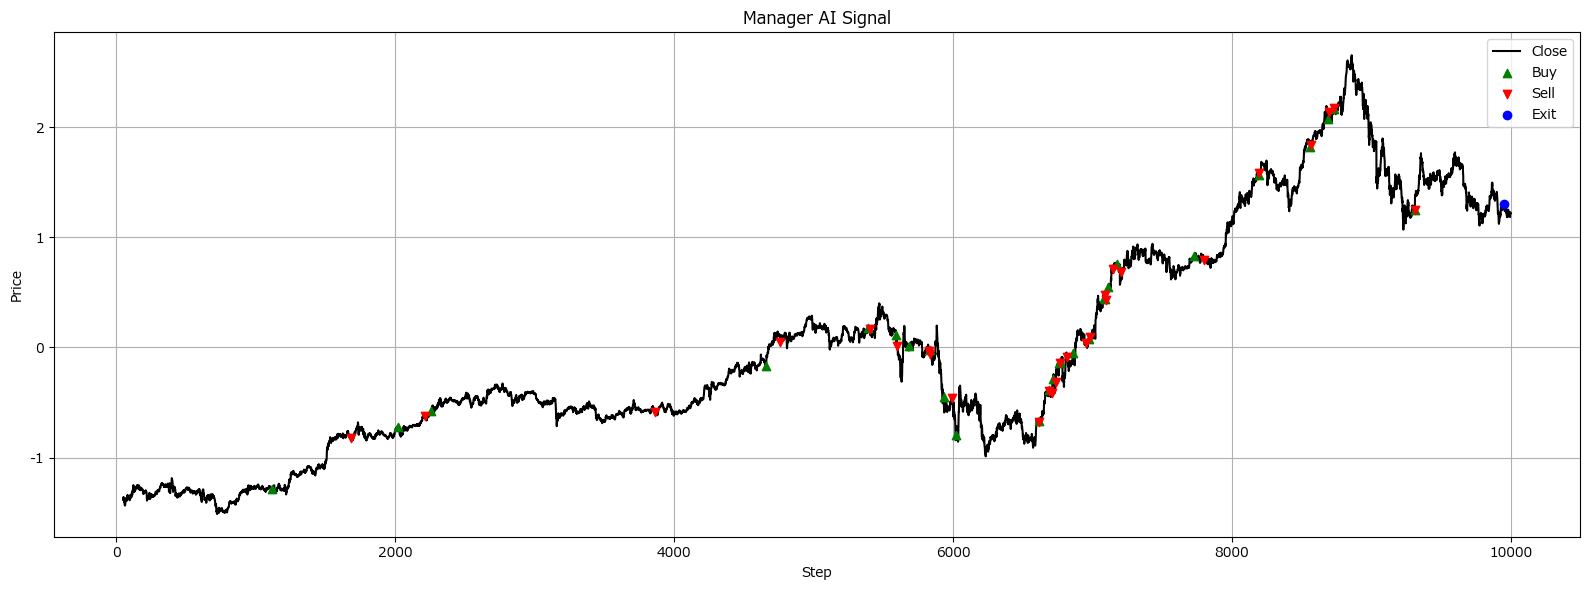

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
##################################################
# run_backtest() の出力を df にマージし、Buy / Sell / Exit シグナル付きのチャートを描画・保存します。
##################################################
# --- フォント設定（Windows対応：日本語表示）---
plt.rcParams["font.family"] = "Meiryo"
plt.rcParams['axes.unicode_minus'] = False  # マイナス記号が文字化けしないように設定

# --- signal列を初期化 ---
df["signal"] = ""  # 空文字で初期化
df["signal"] = df["signal"].astype(object)  # object型に明示変換（文字列 or シグナルを格納）

# 🧠 Manager AIのバックテストを実行し、シグナルを取得
signals = env.run_backtest(manager_model, max_steps=10000)

# --- signals（entry / exit）を df に反映 ---
for step, signal_type, pos in signals:
    if signal_type == "entry":
        df.loc[step, "signal"] = pos  # "long" or "short"
    elif signal_type == "exit":
        df.loc[step, "signal"] = "exit"

# =======================
# 📈 チャート描画処理
# =======================
plt.figure(figsize=(16, 6))
plt.plot(df["close"], label="Close", color="black")  # 終値ライン

# --- エントリー（Buy）シグナル ---
buy_signals = df[df["signal"] == "long"]
plt.scatter(buy_signals.index, buy_signals["close"], marker="^", color="green", label="Buy", zorder=5)

# --- エントリー（Sell）シグナル ---
sell_signals = df[df["signal"] == "short"]
plt.scatter(sell_signals.index, sell_signals["close"], marker="v", color="red", label="Sell", zorder=5)

# --- イグジット（Close）シグナル ---
exit_signals = df[df["signal"] == "exit"]
plt.scatter(exit_signals.index, exit_signals["close"], marker="o", color="blue", label="Exit", zorder=5)

# --- グラフの装飾 ---
plt.title("Manager AI Signal")     # タイトル
plt.xlabel("Step")                 # 横軸ラベル
plt.ylabel("Price")                # 縦軸ラベル
plt.grid(True)
plt.tight_layout()
plt.legend()

# --- グラフ保存（高解像度PNG）---
plt.savefig("manager_signals_chart.png", dpi=300, bbox_inches="tight")
plt.show()
